# Gas Phase UED Fast Analysis
Written by LFH in Dec 2023. 
Adapted from code provided by Yusong Liu and Caidan Moore

1. __Reject images with high counts.__
    * Compared total counts of each image. This is done either based on selected images or based on the standard deviaion of all the images. 
2. __Optional: Subtract background images__
    * Some experiments collect background shots. An average of these is taken and the average is subtracted from each data image. 
    * Alternative method is to generate a background based on the average values of the corners of the images. Right now this is behaving poorly for me.  
3. __Remove outliers instances of identical pixels.__
    * This is generally referred to as removing xray hits or hot pixels. There are two functions for doing this. `rmv_xray_all` runs in parallel and should be used for large datasets and `cleanMean` takes in small data sets.
4. __Mask detector hole__
    * Currently using the code made by collaborators at SLAC as it automatically finds the mask position. This function uses the opencv package. Replaces the mask with nan values.  
    * Only works with small data. Need to figure out why and how to make work with a large data set.  
5. __Calculate static diffraction center.__
    * Using the method provided by collaborators at SLAC found in the `find_beam_center` function. Iteratively fits a circle to the data based on equivalent values in radial positions.  
    * Need to figure out a way to use the individual centers instead of the average. 
6. __Remove radial outliers.__
    * Filter out values which are beyond a threshold compared to equivalent values at other radial positions. This is automatically done in the `azimuthal_avg_correct` function which runs in the background in parallel when calling `get_azimuthal_average`. This function currently uses the multiprocessing package. Would like to switch to concurrent.futures package. __Need to edit__
7. __Apply median filter.__
    * Applies a median filter using the `scipy.ndimage.median_filter` function which requires a set size of grid to filter based on. Before doing this, need to change all nan values to their radial average equivalent.
8. __Calculate azimuthal average.__
    * See point 6. Repeat calculation.


## Import Necessary Functions

In [1]:
# Standard Packages
import numpy as np
from math import exp, sqrt, floor
from tifffile import tifffile as tf
import glob
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import date
import numpy.ma as ma
import scipy
import scipy.signal as ss
import scipy.interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import medfilt2d
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import make_interp_spline
import skimage.transform as skt
import concurrent.futures
import matplotlib
from scipy import signal
#%matplotlib widget

#Image stuff
import matplotlib.patches as patches
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops_table
from skimage import util
import cv2
from pybaselines import Baseline

#ff stuff
import os
from multiprocessing.dummy import Pool as ThreadPool

## Define Functions

### Processing Files

In [20]:
def get_data(file_path, shape = False, file_names = False):
    """
    Generates an array of images of TIFF files.
    
    Arguments:
    
    file_path (string) = Path containing the UED TIFF files. Path can be for a singular image or for a folder containing
                        many files. See examples below for example using //*// format style.
    shape (bool, optional) = Boolean expression. If set to True, function returns the shape of the image data array.
    file_names (bool, optional) = Boolean Expression. If set to true, function returns the list of file names.
    
    Returns: data_array, shape (if True), file_names (if True)
    
    numpy array or tuple: 
            If shape = False, file_names = False: Returns numpy array containing data from tiff files as a n x shape x shape (shape refers to the
                                dimensions of the TIFF file, typically 1024 x 1024).
            If shape = True: returns tuple. First element is a numpy array containing data from tiff files as a n x shape x shape
                                (shape refers to the dimensions of the TIFF file, typically 1024 x 1024). Second element is the dimensions
                                of the data array as a tuple.
            If file_names = True: returns tuple containing data array and list with file names.
            
    
    Examples:
    
    file_path = "Desktop/Folder/Data_Analysis/20034291//*//*//ANDOR1_*.tif"
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]]
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]], (220, 1024, 1024)
    
    Notes:
        - All images must be of same dimension. If images of different shapes needed, either group them by shape and run this function for
            each file shape or create it manually by reading files into a numpy array with dtype = object. Be careful as this can lead to 
            later problems
        - Review "*" notation to read in all files of a singular type. Expedites the process.
    
    """
    files = glob.glob(file_path) #read in file name
    if not files:
        FileNotFoundError(f"file_path input does not contain any TIFF files: {file_path}")
    data_array = tf.imread(files) # construct array containing files
    if shape and file_names:
        return data_array, data_array.shape, files
    elif shape:
        return data_array, data_array.shape
    elif file_names:
        return data_array, files
    else:
        return data_array
    
def stagePosition(file_names, idx_start, idx_end, unique_positions = False ):
    """
    Finds the stage position in the string for every file name in the list of all TIFF files. Requires the user to find the
    index of the first digit and last digit of a single file and assumes all files are formatted identically. It uses these indices
    to retrieve the digits from the file names and stores them in a list. All files must have the exact same number of characters before
    the stage position in the name of the file. If this is an issue, group the file names by preceding characters and run this function
    on each list of files.
    
    If unique_positions = False, it returns the stage positions as a numpy array. If unique_positions = True, it returns a tuple
                        containing an array of the stage positions, an array of the unique stage positions, and an array containing
                        the indices of the unique stage positions in the original array.
    Arguments: 
    
    file_names (list containing strings): List of file names
    idxStart (int): the index of the first digit of the stage position in the file name
    idxEnd (int): the index of the last digit of the stage position in the file name
    unique_positions
    
    Returns: stage_pos, uniq_stage (optional), uniq_stage_idx (optional)
    
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    uniq_stage (array): Optional. A numpy array containing the unique stage positions listed in ascending order.
    uniq_stage_idx (array): Optional. A numpy array containing the indices of the unique stage positions in the original input array.
    
    Examples:
    
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    >>> stagePosition(file_names, 9, 11)
        [10. 20. 40. 30. 40.]
    
    >>> stagePosition(file_names, 9, 11, unique_positions = True)
        (array([10., 20., 40., 30., 40.]), array([10., 20., 30., 40.]), array([0, 1, 3, 2]))

    """
    try:
        try:
            stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            stage_pos = np.array(stage_pos)
            if unique_positions == True:
                uniq_stage, uniq_stage_idx = np.unique(stage_pos, return_index = True)
                return stage_pos, uniq_stage, uniq_stage_idx
            else:
                return stage_pos
            return stagePos
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names.""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")

def get_counts(data_array, plot = False):
    """
    Generates the counts from the given data by summing over the array elements. Returns 2d array of the same dimension as the
    input images.
    
    Arguments:
    
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    plot (bool, optional): If set to true, generates a graph of the counts data.
    
    Returns:
    counts (numpy.ndarray): One dimensional numpy array containing the data after summing over each array element.
    
    Example:
    
    data = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
    >>>countData(data)
        array([21, 51])
    """
    counts = np.sum(data_array, axis = (1,2))
    if len(data_array) == 0:
        raise ValueError("Input data_array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data_array is not 3 dimensional.")
    if plot == True:
        plt.plot(np.arange(len(data_array[:, 0, 0])), counts)
        plt.show()
    return counts

# def get_image_details(file_names):
#     """
#     Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage positions, the
#     file order number, and the number of counts per image.
    
#     Arguments: 
#     data_array (numpy.ndarray): Numpy data array containing the diffraction images.
#     file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
#     Returns:
#     data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
#     stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
#                             the index of the file name in file_names.
#     file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
#     counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

#     """
#     data_array = tf.imread(file_names) # construct array containing files
    
#     try:
#         stage_pos = []
#         file_order = []
#         try:
#             #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
#             #stage_pos = np.array(stage_pos)
#             for file in file_names:
#                 string = list(map(str, file.split("/")))
#                 string = list(map(str, string[-1].split("-")))
#                 file_order.append(int(string[1]))
#                 string = list(map(str, string[-1].split("_")))
#                 stage_pos.append(float(string[0]))
#         except ValueError:
#             raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. Also check separators""")
#     except IndexError:
#         raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
#     stage_pos = np.array(stage_pos)
#     file_order = np.array(file_order)
    
#     counts = get_counts(data_array)
    
#     return data_array, stage_pos, file_order, counts 


def get_image_details_slac(file_names, sort=True):
    """
    WORKS FOR CURRENT DATA COLLECTION
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage positions, the
    file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    
    try:
        stage_pos = []
        file_order = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                string = list(map(str, file.split("/")))
                string = list(map(str, string[-1].split("_")))
                file_order.append(int(string[2]))
                stage_pos.append(float(string[3]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
        
        
    stage_pos = np.array(stage_pos)
    file_order = np.array(file_order)
    counts = get_counts(data_array)
    
    if sort == True:
        idx_sort = np.argsort(file_order)
        file_order = file_order[idx_sort]
        data_array = data_array[idx_sort]
        stage_pos = stage_pos[idx_sort]
        counts = counts[idx_sort]
    
    return data_array, stage_pos, file_order, counts 

def get_image_details_ontph(file_names, sort=True):
    """
    WORKS FOR CURRENT DATA COLLECTION
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage positions, the
    file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    
    try:
        stage_pos = []
        file_order = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                string = list(map(str, file.split("/")))
                string = list(map(str, string[-1].split("_")))
                string = list(map(str, string[1].split("-")))
                print(string)
                file_order.append(int(string[1]))
                stage_pos.append(float(string[2]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
        
        
    stage_pos = np.array(stage_pos)
    file_order = np.array(file_order)
    counts = get_counts(data_array)
    
    if sort == True:
        idx_sort = np.argsort(file_order)
        file_order = file_order[idx_sort]
        data_array = data_array[idx_sort]
        stage_pos = stage_pos[idx_sort]
        counts = counts[idx_sort]
    
    return data_array, stage_pos, file_order, counts 


def get_image_details_keV(file_names, sort=False):
    """
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage 
    positions, the file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    
    try:
        ir_stage_pos = []
        uv_stage_pos = []
        file_order = []
        current = []
        try:
            for file in file_names:
                string = list(map(str, file.split("/")))
                #temp = list(map(str, string[6].split(" ")))
                #folder_number = temp[2]
                string = list(map(str, string[-1].split("_")))
                #file_number = int(folder_number + string[1])
                #file_order.append(int(file_number))
                ir_stage_pos.append(float(string[4]))
                uv_stage_pos.append(float(string[6]))
                current.append(float(string[-1][:-5]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. 
            Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
    ir_stage_pos = np.array(ir_stage_pos)
    uv_stage_pos = np.array(uv_stage_pos)
    file_order = np.array(file_order)
    current = np.array(current)
    counts = get_counts(data_array)
    
    if sort == True:
        idx_sort = np.argsort(file_order)
        file_order = file_order[idx_sort]
        data_array = data_array[idx_sort]
        ir_stage_pos = ir_stage_pos[idx_sort]
        uv_stage_pos = uv_stage_pos[idx_sort]
        counts = counts[idx_sort]
        current = current[idx_sort]
    
    return data_array, ir_stage_pos, uv_stage_pos, file_order, counts, current

### Cleaning Functions

In [3]:
def clean_and_filter(data_array):
    """Takes in a 3D array of data and applies the scipy.ndimage.median_filter on them. Need to consider the box size for these filters. 
        Additionally, issues can arise if the data array has nan values. 
        
        Returns: filtered data array of the same size as the input array"""
    
    print("Cleaning data")
    clean_data_array = []
    for data in data_array:
        new_data = data
        filt_data = median_filter(new_data, size=3)
        clean_data_array.append(np.array(filt_data))
    
    return clean_data_array

def _clean_and_filter(data_array_1d):
    """Takes in a large 3D array of data and applies the scipy.ndimage.median_filter on them in parallel processing. 
    Need to consider the box size for these filters. Additionally, issues can arise if the data array has nan values. Eventually would like to add
    A baseline subtraction to this code.

    Returns: filtered data array of the same size as the input array"""
    
    #corners = (np.median(data_array_1d[-50:, -50:]), np.median(data_array_1d[-50:, :50]), np.median(data_array_1d[:50, -50:]), 
                    #np.median(data_array_1d[:50, :50]))
    #floor = float(np.mean(corners))
    new_data = data_array_1d
    filt_data = median_filter(new_data, size=3)
    
    return filt_data


def clean_all(data_array):
    """Takes in a large 3D array of data and applies the scipy.ndimage.median_filter on them in parallel processing using the hidden function
    _clean_and_filter. Need to consider the box size for these filters. Additionally, issues can arise if the data array has nan values. 
    Eventually would like to add a baseline subtraction to this code.

    Returns: filtered data array of the same size as the input array"""
    
    print('Cleaning all data with concurrent.futures.ProcessPoolExecutor')
    filtered_data = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(_clean_and_filter, data_array)
        
    for result in results:
        filtered_data.append(result)
    
    filtered_data = np.array(filtered_data)
    print(filtered_data.shape)
    print("Finished cleaning!!")
    return filtered_data

def rmv_xrays_all(data_array):
    """ Requires global variables for the mean and standard deviation. Filters out any pixels that are more than 4 times the standard deviation of 
    the average pixel value by running the hidden function _remove_xrays in parallel. Use cleanMean if not a large dataset.
    
    Returns: xray removed data sets of the same shape."""
    print("Removing xrays from all data")
    clean_data = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(_remove_xrays, data_array)
    for result in results:
        clean_data.append(result)
    pct_rmv = []
    for i in range(len(clean_data)):
        no_rmv = sum(sum(clean_data[i].mask))
        pct_rmv.append(no_rmv/(1024*1024) * 100)
    clean_data = np.array(clean_data)
    print(clean_data.shape)
    
    pct_rmv = np.array(pct_rmv)
    plt.figure()
    plt.plot(pct_rmv)
    plt.title("Percent Pixels Removed")
    plt.xlabel("Image Number")
    plt.ylabel("Percent")
    plt.show()
    
    return clean_data
        

def _remove_xrays(data_array_1d):
    upper_threshold = mean_data + 4*std_data
    clean_data = ma.masked_greater_equal(data_array_1d, upper_threshold)
    return clean_data
            
def cleanMean(data_array, std = 4, return_clean_data = True):
    """
    Takes in a data array and calculate the mean and standard deviation at each index across all images. Then applies a filter
    to the data that masks all values (replaces outliers with nan's) outside a given number of standard deviations. After, the 
    mean is taken, returning a 2 dimensional array with the mean data of non-outlier entries across all images.
    
    If return_clean_data is set to True, the cleaned data is returned as a 3d array without having the mean taken.
    
    Arguments:
    
    data_array (numpy.ndarray): Data array containing diffraction image data.
    std (int or float): Number of standard deviations from the mean allowed. Values outside this number of standard deviations
                        are masked as nan's. Set to 3 by default.
                        
    Returns:
    
    clean_mean_data (numpy.ndarray): Default. Returns a 2 dimensional array containing the mean values of the cleaned data.
    clean_data (numpy.ndarray): Other option. Returns the raw 3 dimensional array containing the cleaned data.
    
    Examples:
    
    example_array = np.array([[[8.,2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]], [[1., 2], [1,2]]])
    
    >>> cleanMean(example_array, std=1)
        np.array([[1.,2],[1.,2]])
    
    >>> cleanMean(example_array, std=1, return_clean_data = True)
        np.array([[[np.nan, 2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]]])
    """
    if len(data_array) == 0:
        raise ValueError("Input data array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data array is not 3 dimensional.")
    if std <= 0:
        raise ValueError("Number of standard deviations (std) must be non-negative.")
    if not isinstance(return_clean_data, bool):
        raise TypeError("return_clean_data must be a boolean value.")
   
    mean = np.mean(data_array, axis = 0)
    stDev = np.std(data_array, axis = 0)
    upper_threshold = mean + std*stDev
    #lower_threshold = mean - std*stDev
    clean_data = ma.masked_greater_equal(data_array, upper_threshold)
    #clean_data = ma.masked_outside(data_array, lower_threshold, upper_threshold)
    pct_rmv = []
    for i in range(len(clean_data)):
        no_rmv = sum(sum(clean_data[i].mask))
        pct_rmv.append(no_rmv/(1024*1024) * 100)

    pct_rmv = np.array(pct_rmv)
    plt.figure()
    plt.plot(pct_rmv)
    plt.title("Percent Pixels Removed")
    plt.xlabel("Image Number")
    plt.ylabel("Percent")
    plt.show()
    if return_clean_data == True:
        return clean_data
    else:
        clean_mean_data = np.mean(clean_data, axis = (0))
        return clean_mean_data
    
def medianFilter(data_array, center_top_left_corner, center_border_length, med_filter_range = 3):
    """
    Takes in a data array and applies scipy.signal's median filter. Then replaces the boundary and center values with the
    original values from the input array as to not lose precision in these parts. 
    
    Arguments:
    
    data_array (np.array): 2d Numpy array containing diffraction image data.
    center_top_left_corner (tuple): Tuple containing the row index (integer) and column index (integer) of the top left corner
                                    (lowest_index_row, lowest_index_column)
    center_border_length (int): Length of one side of the square. Must be an integer.
    med_filter_range (int): Must be odd. Initially set to 3. Shape of the square array for median filtering. Using an odd values makes it so that 
    the median filter is centered around the individual point.
    
    Returns:
    
    med_filt_data (2d-array): Array containing the median filtered data.
            
    """
    if not isinstance(data_array, np.ndarray):
        raise ValueError("Input data_array must be a 2D numpy array.")
    if not isinstance(center_top_left_corner, tuple) or len(center_top_left_corner) != 2:
        raise ValueError("Center top left corner must be a tuple of length 2 that contains two integers.")
    if not isinstance(center_border_length, int):
        raise ValueError("center_border_length must be an integer.")
    #if not isinstance(center_top_left_corner[0] + center_border_length < data_array[0,-1]  
    if not (0 <= center_top_left_corner[0] < data_array.shape[0] and
        0 <= center_top_left_corner[1] < data_array.shape[1] and
        center_top_left_corner[0] + center_border_length <= data_array.shape[0] and
        center_top_left_corner[1] + center_border_length <= data_array.shape[1]):
        raise ValueError("""center_top_left_corner is out of bounds or adding center_border_length goes beyond the array.
                     Check that the tuple values are positive integers within the bounds of the data array and that 
                     adding the border length does not result in a value beyond the size of the array.""")
    if not isinstance(med_filter_range, int) and med_filter_range % 2 == 1:
        raise ValueError("med_filter_range must be an odd integer.")

    med_filt_data = ss.medfilt2d(data_array, med_filter_range)
    med_filt_data[0:med_filter_range//2,:] = data_array[0:med_filter_range//2,:]
    med_filt_data[-(med_filter_range//2):0,:] = data_array[-(med_filter_range//2):0,:]
    med_filt_data[:,0:med_filter_range//2] = data_array[:,0:med_filter_range//2]
    med_filt_data[:,-(med_filter_range//2):] = data_array[:,-(med_filter_range//2):]
    row_s, col_s = center_top_left_corner
    row_e, col_e = row_s+center_border_length, col_s+center_border_length
    med_filt_data[row_s:row_e,col_s:col_e] = data_array[row_s:row_e,col_s:col_e]
    return med_filt_data

def backgroundNoise(data_array, bkg_range = 20, remove_noise = False):
    """
    Takes in a 2d data array (using the mean array is recommended) and calculatees the means of the corners. Linearly interpolates values across 2d
    array to generate of background noise values using pandas.DataFrame.interpolate. Returns a two dimensional numpy array with the linearly 
    interpolated background noise.

    Arguments:

    data_array (2d np.ndarray): Data array used to generate the corner values of the background noise.
    bkg_range (int): Side length of square in each corner used for generating mean value. Initially set to 20.
    remove_noise (Bool): If set to true, generated background values are subtracted from the initial input array. Returns cleaned data.
    
    Returns:
    
    bkg_data (2d np.ndarray): Data array containing the linearly interpolated background noise for the image. If remove_noise = True,
                                returned data has background noise removed from original input.
    """
    if not isinstance(data_array, np.ndarray):
        raise ValueError("Input data_array must be a numpy array.")
    if not isinstance(bkg_range, int) and bkg_range > 0:
        raise ValueError("bkg_range must be an integer > 0.")
    if not isinstance(remove_noise, bool):
        raise ValueError("remove_noise must be a boolean.")
    if not (2 * bkg_range < len(data_array[0,:]) and
            2 * bkg_range < len(data_array[:,0])):
        raise ValueError("2 * bkg-range must be less than both the number of rows and the number of columns.")

    empty_array = np.empty(np.shape(data_array))
    empty_array = (ma.masked_array(empty_array, mask = True))
    empty_array[0,0] = np.mean(data_array[0:20,0:20])
    empty_array[-1,0] = np.mean(data_array[-20:,0:20])
    empty_array[0,-1] = np.mean(data_array[0:20,-20:])
    empty_array[-1,-1] = np.mean(data_array[-20:,-20:])
    empty_array = pd.DataFrame(empty_array).interpolate(axis = 0)
    empty_array = pd.DataFrame(empty_array).interpolate(axis = 1)
    bkg_data = pd.DataFrame.to_numpy(empty_array)
    if remove_noise == True:
        return data_array - bkg_data
    else:
        return bkg_data
    
def gaussian_filter_2d(data_array, sig=1):
    """Applies the scipy.ndimage.gaussian_filter() on the 2D data array. Returns filtered images"""
    gf_filtered = gaussian_filter(data_array, sig)
    return gf_filtered

def normalize_to_baseline(data, posi_1=80, posi_2=200):
    data[:, :25] = np.nan
    data_mean = np.nanmean(data, axis=0)
    norm_factor = np.nansum(data_mean[posi_1:posi_2])
    data_norm = []
    for i in range(len(data)):
        offset = np.nansum(data[i, posi_1:posi_2])
        norm = data[i]*(norm_factor/offset)
        data_norm.append(norm)
        
    data_norm = np.array(data_norm)
    return data_norm

def power_fit(data_array, x_vals, degree, return_baseline=False):
    if len(data_array.shape) == 2:
        baseline2d = []
        for i in range(len(data_array)):
            temp_data = np.copy(data_array[i])
            idx_nan = ~np.isnan(temp_data)
            coeff = np.polyfit(x_vals[idx_nan],temp_data[idx_nan],degree)
            baseline = np.polyval(coeff,x_vals)
            baseline2d.append(baseline)

        baseline2d = np.array(baseline2d)
        corrected_data = data_array - baseline2d
        
    elif len(data_array.shape) == 1:
        temp_data = data_array
        idx_nan = ~ np.isnan(temp_data)
        coeff = np.polyfit(x_vals[idx_nan], temp_data[idx_nan], 2)
        baseline2d = np.polyval(coeff, x_vals)
        
        corrected_data = data_array - baseline2d
    else:
        print("Data Array must be 1D or 2D array")
    if return_baseline == True:
        return corrected_data, baseline2d
    else:
        return corrected_data
    
def fit_high_s(data_array, x_vals, s_range, return_baseline=False):
    if len(data_array.shape) == 2:
        corrected_data = []
        baseline = []
        for i in range(len(data_array)):
            temp_data = data_array[i]
            coeff = np.polyfit(x_vals[s_range], temp_data[s_range], 2)
            line = np.polyval(coeff, x_vals[s_range])
            baseline.append(line)
            data_array[i, s_range] = temp_data[s_range] - line
            corrected_data.append(data_array[i])
            
    elif len(data_array.shape) == 1:
        coeff = np.polyfit(x_vals[s_range], data_array[s_range], 1)
        baseline = np.polyval(coeff, x_vals)
        
        corrected_data = data_array - baseline
    else:
        print("Data Array must be 1D or 2D array")
    
    corrected_data= np.array(corrected_data)
    
    if return_baseline == True:
        return corrected_data, baseline
    else:
        return corrected_data
    

### Masking Functions

In [4]:
def detectorMask(data_array, hole_center, inner_radius, outer_radius, plot_image = True):
    """
    Takes in a 2d data array and applies a circular (donut shaped) detector mask to it, replacing the masked values with np.nan's.
    Returns the masked, 2d data array.

    Arguments:
    
    data_array (2d np.ndarray): 2d data array to be masked.
    hole_center (tuple): Tuple containing the x and y coordinates of the center of the image, each one of which an int.
    inner_radius (float): Inner radius. Values within the radius of this drawn from the center are masked.
    outer_radius (float): Outer radius of the donut. Values outside the radius of this drawn from the center are masked.
    plot_image (bool, optional): If True, plots the masked image. Default is False.

    Returns:
    ring_data (2d np.ndarray): Data array with the circular detector mask applied.
    """
    if not isinstance(hole_center, tuple) or len(hole_center) != 2:
        raise ValueError("hole_center must be a tuple of length 2 containing the x and y coordinates of the hole center.")
    if not (isinstance(inner_radius, (int, float)) and inner_radius > 0):
        raise ValueError("inner_radius must be a positive float or integer.")
    if not (isinstance(outer_radius, (int, float)) and outer_radius > 0):
        raise ValueError("outer_radius must be a positive float or integer.")
    if inner_radius >= outer_radius:
        raise ValueError("inner_radius must be smaller than outer_radius.")


    hole_cx, hole_cy = hole_center
    x_idx, y_idx = np.meshgrid(np.arange(data_array.shape[2]), np.arange(data_array.shape[1]))
    dist = np.sqrt(((x_idx - hole_cx)**2 + (y_idx-hole_cy)**2))
    mask = np.logical_and(dist<=outer_radius, dist>= inner_radius)
    ring_data = []
    for i in range(len(data_array)):
        data = np.where(mask, data_array[i], np.nan)
        ring_data.append(data)
        
    ring_data = np.array(ring_data)
    if plot_image == True:
        img3 = plt.imshow(ring_data[0])
        plt.colorbar(img3)
    return(ring_data)

    
def mask_hole(I,fit_bor,hole_bor,value_bor,show='yes'):
       
    [X_fit,Y_fit]=np.where((I[fit_bor[0][0]:fit_bor[0][1],fit_bor[1][0]:fit_bor[1][1]]<1.1*value_bor) &
                           (I[fit_bor[0][0]:fit_bor[0][1],fit_bor[1][0]:fit_bor[1][1]]>0.9*value_bor))
    if show=='yes':
        plt.scatter(Y_fit+fit_bor[1][0],X_fit+fit_bor[0][0])
    center_hole,r_hole=fit_circle([X_fit+fit_bor[0][0],Y_fit+fit_bor[1][0]])
    
    mask=np.ones((hole_bor[0][1]-hole_bor[0][0],hole_bor[1][1]-hole_bor[1][0])).astype(float)
    for xi in range(len(mask)):
        for yi in range(len(mask[xi])):
            if (xi-center_hole[0]+hole_bor[0][0])**2 + (yi-center_hole[1]+hole_bor[1][0])**2 <= (r_hole+3)**2:
                mask[xi,yi]=np.nan
    I[hole_bor[0][0]:hole_bor[0][1],hole_bor[1][0]:hole_bor[1][1]]=I[hole_bor[0][0]:hole_bor[0][1],hole_bor[1][0]:hole_bor[1][1]]*mask
    
    return mask,center_hole,r_hole

### Center Finding

In [5]:
# def find_beam_center(I,center=[500,500],r=175,printr2='no',recursiontime=0):

#     recursiontime+=1
#     #up down right left,r away pixles average
#     fit_value=np.average([I[center[0]+r][center[1]],I[center[0]-r][center[1]],I[center[0]][center[1]+r],I[center[0]][center[1]-r]])
    
#     [X_f,Y_f]=np.where((I>0.999*fit_value) & (I<1.001*fit_value))
    
#     #plt.figure()
#     #plt.scatter(Y_f,X_f)
#     #plt.imshow(I)
#     a=len(X_f)
#     i=0
#     #delete fit_points which are too far away from fit_circle, range from 0.5r to 1.5r
#     while(i<a):
#         ri2=(X_f[i]-center[0])**2+(Y_f[i]-center[1])**2
#         if (ri2>(1.5*r)**2) or (ri2<(0.5*r)**2):
#             X_f=np.delete(X_f,i)
#             Y_f=np.delete(Y_f,i)
#             i-=1
#             a-=1
#         i+=1
#     center_new,r_new=fit_circle([X_f,Y_f],printr2)
    
#     if r_new==0:
#         return [0,0]
#     elif ((center[0]-center_new[0])**2 +(center[1]-center_new[1])**2) <=1 :
#         #new center pretty close to old center
#         return center_new
#     elif recursiontime>=10:
#         return [0,0]
#     else:
#         #else: iterate
#         return find_beam_center(I,center_new,r_new,recursiontime=recursiontime)
    
    
    
# def fit_circle(fit_points,printr2='yes'):
    
#     #circle function: ax+by+c=-(x^2+y^2)
    
#     A=np.empty((len(fit_points[0]),3))
#     B=np.empty(len(fit_points[0]))
    
#     for i in range(len(fit_points[0])):
#         B[i]=-(fit_points[0][i]**2+fit_points[1][i]**2)
#         A[i][0]=fit_points[0][i]
#         A[i][1]=fit_points[1][i]
#         A[i][2]=1
    
#     #A[i]=[xi,yi,1], B[i]=-(xi^2+yi^2), par=[a,b,c]
#     #namely A*par=B, least square method
#     if np.linalg.det(np.dot(A.T,A)) == 0:
#         return [],0
#     par=np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)),A.T),B)
    
#     #correlation coeff, if not very close to 1(less than 3 nines), be careful
#     if printr2=='yes':
#         y_ave=np.mean(B)
#         r2=np.sum((np.dot(A,par)-y_ave)**2)/np.sum((B-y_ave)**2)
#         print(r2)
    
#     center_new=[round(-par[0]/2),round(-par[1]/2)]
#     r_new=round(np.sqrt(par[0]**2+par[1]**2-4*par[2])/2)
    
#     return center_new,r_new


def find_beam_center(I,center=[500,500],r=200,printr2='no',recursiontime=0):

    recursiontime+=1
    #up down right left,r away pixles average
    # fit_value=average([I[center[0]+r][center[1]],I[center[0]-r][center[1]],I[center[0]][center[1]+r],I[center[0]][center[1]-r]])
    fit_value= np.average([I[round(center[0])+r][round(center[1])],I[round(center[0])-r][round(center[1])],I[round(center[0])][round(center[1])+r],I[round(center[0])][round(center[1])-r]])

    [X_f,Y_f]= np.where((I>0.999*fit_value) & (I<1.001*fit_value))

    a=len(X_f)
    i=0
    #delete fit_points which are too far away from fit_circle, range from 0.5r to 1.5r
    while(i<a):
        ri2=(X_f[i]-center[0])**2+(Y_f[i]-center[1])**2
        if (ri2>(1.5*r)**2) or (ri2<(0.5*r)**2):
            X_f=np.delete(X_f,i)
            Y_f=np.delete(Y_f,i)
            i-=1
            a-=1
        i+=1
            
    center_new,r_new=fit_circle([X_f,Y_f],printr2)
    
    if r_new==0:
        return [0,0]
    elif ((center[0]-center_new[0])**2 +(center[1]-center_new[1])**2) <=1 :
        #new center pretty close to old center
        return center_new
    elif recursiontime>=10:
        return [0,0]
    else:
        #else: iterate
        return find_beam_center(I,center_new,r_new,recursiontime=recursiontime)
    
    
    
def fit_circle(fit_points,printr2='yes'):
    
    #circle function: ax+by+c=-(x^2+y^2)
    
    A= np.empty((len(fit_points[0]),3)) # Find center for 3 thimes
    B= np.empty(len(fit_points[0]))
    
    for i in range(len(fit_points[0])):
        B[i]=-(fit_points[0][i]**2+fit_points[1][i]**2)
        A[i][0]=fit_points[0][i]
        A[i][1]=fit_points[1][i]
        A[i][2]=1
    
    #A[i]=[xi,yi,1], B[i]=-(xi^2+yi^2), par=[a,b,c]
    #namely A*par=B, least square method
    if np.linalg.det(np.dot(A.T,A)) == 0:
        return [],0
    par=np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)),A.T),B)
    
    #correlation coeff, if not very close to 1(less than 3 nines), be careful
    if printr2=='yes':
        y_ave=np.mean(B)
        r2=sum((np.dot(A,par)-y_ave)**2)/sum((B-y_ave)**2)
        print(r2)
    
    center_new=[(-par[0]/2),(-par[1]/2)] # no-Round the center, not working for the moment
    r_new=round(np.sqrt(par[0]**2+par[1]**2-4*par[2])/2) # no-round the r range, not working for the moment
    # print('ct found:'+str(center_new))
    
    # center_new=[round(-par[0]/2),round(-par[1]/2)] # Round the center
    # r_new=round(sqrt(par[0]**2+par[1]**2-4*par[2])/2) # round the r range
    
    return center_new,r_new

### Azimuthal Averaging

In [6]:
def azimuthal_integration(data_array, center, correction_factor=3):
    """
    Performs azimuthal integration over the data set, removing radial outliers as it performs the integration. 
    Function coverts to polar coordinates, the calculates the mean and std at every radial distance (distances are
    previously round to the nearest positive integer and grouped by integer). Returns the azimuthal integration data
    and the azimuthal error.
    
    Arguments:
    
    data_array (np.ndarray): Two dimensional numpy array containing the diffraction image. 
    center (tuple): Tuple containing the integer coordinates of the image center.
    correction_factor (int, optional): Number of standard deviations set as threshold. Preset to 3.
    
    Return: (azi_dat, azi_err)
    
    azi_dat (np.ndarray): Array containing the integrated data.
    azi_err (np.ndarray): Array containing the error of the integrated data.
    
    Example:
    
    sample_array = np.random.rand(100,100)
    center = (40,40)
    
    >>> azimuthal_integration(sample_array, center, correction_factor = 2)
        azi_dat, azi_err
    """

    
    x_mat, y_mat = np.meshgrid(np.arange(0,data_array.shape[1],1)-center[1],np.arange(0,data_array.shape[0],1)-center[0])
    #rmat, _ = cart2pol(xmat, ymat)
    
    r_mat = np.sqrt(x_mat**2 + y_mat**2)
    #phi = np.arctan2(y_mat,x_mat)
                               
    rmat = np.around(r_mat)
    data_array = data_array.astype(float)
    data_array[data_array==0] = np.nan
    x_length = int(np.amax([np.amax(abs(x_mat)),np.amax(abs(y_mat))]))
    azi_dat = np.zeros(x_length)
    azi_err = np.copy(azi_dat)
    for i in range(x_length):
        roi = data_array[r_mat==int(i+1)].astype(float)
        #print(roi)
        if len(roi)==0:
            break
        std = np.nanstd(roi)
        idxx = np.logical_and(roi <= np.nanmean(roi)+correction_factor*std,roi >=np.nanmean(roi)-correction_factor*std)
        idxx = util.invert(idxx)
        roi[idxx] = np.nan
        
        azi_dat[i] = np.nanmean(roi)
        azi_err[i] = np.nanstd(roi)/np.sqrt(abs(np.nansum(roi)))
    return azi_dat, azi_err

def azimuthal_avg_correct(args):
    """Returns the azimuthal average of a diffraction image based on the radial distance of the x, y positions in the image."""
    data, x, y = args
    r_max=len(x)
    I=np.empty(r_max)
    for ri in range(r_max):
        I_r=data[x[ri],y[ri]]
        ave=np.nanmean(I_r)
        sigma=np.nanstd(I_r)
        I_r[np.abs(I_r-ave)>=5*sigma]=np.nan
        I[ri]=np.nanmean(I_r)
    return I

def get_azimuthal_average(data,x,y):
    """Runs the azimuthal average function in parallel for large data sets."""
    p = ThreadPool(3)
    I=p.map(azimuthal_avg_correct, [(data_i,x,y) for data_i in data]) 
    return np.array(I)

def get_average_old(array):
    """Return the average and standard deviation of an array"""
    Sum = 0
    Sum_squared = 0
    for element in array:
        if element == None:
            continue # Skip empty values
        Sum += element
        Sum_squared += element**2
    length = len(array)
    if length == 0:
        return 0, 0
    average = Sum / length 
    stdev = sqrt(Sum_squared / length - average**2) # sigma^2 = <X^2> - <X>^2
    return average, stdev

def get_average(array):
    average = np.nanmean(array)
    stdev = np.nanstd(array)
    return average, stdev

def get_radial_distribution(image):
    """Get average radial intensity after eliminating outliers"""
    radial_range = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER)) #half the size of the image i.e. 512 for 1024 by 1024 image
    radial_values = [[] for r in range(radial_range)]
    # First get all pixel values for each radial position as an array that we can average over later
    # It will look like
    #   [ (R = 0 values) [...],
    #     (R = 1 values) [...],
    #     (R = 2 values) [...], etc ]

    for Y in range(GRID_SIZE):
        for X in range(GRID_SIZE):
            R = sqrt((X - X_CENTER)**2 + (Y - Y_CENTER)**2)
            R_index = int(round(R))
            if R_index < len(radial_values):
                radial_values[R_index].append(image[X][Y])
    # So now we have an array where, for each R value, we have a sub-array of each pixel intensity at that R
    # We want to first calculate the average and standard deviation
    # Then eliminate all outliers that are >3sigma away from the average
    # Then re-calculate the average with all outliers removed
    radial_averages, radial_stdevs = [], []
    for r_values in radial_values:
        avg, stdev = get_average(r_values)
        # Create new list with outliers removed
        new_r_values = [r if abs(avg - r) <= 5*stdev else np.nan for r in r_values]
        new_avg, new_stdev = get_average(new_r_values)
        radial_averages.append(new_avg)
        radial_stdevs.append(new_stdev)
    
    return radial_averages, radial_stdevs

def remove_radial_outliers(image):
    """After finding average radial values, replace all outlier pixels with the average value at that radius"""
    radial_avgs, radial_stdevs = get_radial_distribution(image)

    new_image = [[0 for Y in range(GRID_SIZE)] for X in range(GRID_SIZE)] # image of all zeros

    for Y in range(GRID_SIZE):
        for X in range(GRID_SIZE):
            R = sqrt((X - X_CENTER)**2 + (Y - Y_CENTER)**2)
            # Calculate the interpolated value for the average and stdev at this R
            # (Same thing I do in simulate_image but now I'm calculating the weighted average of the 
            # average intensity values so the language is a little confusing)
            interpolated_avg, interpolated_stdev = 0, 0 # Will be filled in with the interpolated values

            R_lower = floor(R)
            R_upper = R_lower + 1
            if R_lower >= len(radial_avgs):
                interpolated_avg = 0 # R value is out of bounds, default to 0
                interpolated_stdev = 0
            elif R_upper >= len(radial_avgs):
                interpolated_avg = radial_avgs[R_lower] # R value is just outside of bounds, default to edge value
                interpolated_stdev = radial_stdevs[R_lower]
            else:
                # Calculate weighted average
                interpolated_avg = (R - R_lower) * radial_avgs[R_upper] + (R_upper - R) * radial_avgs[R_lower]
                interpolated_stdev = (R - R_lower) * radial_stdevs[R_upper] + (R_upper - R) * radial_stdevs[R_lower]
            
            if abs(image[X][Y] - interpolated_avg) <= 3*interpolated_stdev:
                # Value is within acceptance range, do not change
                new_image[X][Y] = image[X][Y] 
            else:
                # Value is outside acceptance range, use average value instead
                new_image[X][Y] = interpolated_avg
    
    return new_image

## Reading in Data and Visualizing

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [7]:
dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320'
#dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180623/Run/20180623_2349'
#dataPath = '/work/centurion/lheald2/cf3i_kev/01142024/cf3i_ir_uv/Scan 6/'
#dataPath = '/work/centurion/lheald2/cf3i_kev/01152024/01152024/cf3i_uv_ir/Scan 5/'
#dataPath = '/work/centurion/lheald2/cf3i_kev/01202024/Scan 2/'
#dataPath = '/work/centurion/lheald2/cf3i_kev/01172024/cf3i_uv_ir/Scan 5/'
#dataPath = '/work/centurion/lheald2/cf3i_kev/01182024/cf3i_uv_ir/Scan 1/'
#runPath = '*.tiff'
runPath = "/*/*/ANDOR1_*.tif"
image_path = dataPath + 'Images/'
print(image_path)


#bkg_path = '/work/centurion/lheald2/cf3i_kev/01152024/01152024/cf3i_uv_ir/bkg/Images 2/*.tiff'
bkg_path = '/work/centurion/lheald2/cf3i_kev/01182024/cf3i_uv_ir/bkg/Images 1/*.tiff'
#ref_path = '/work/centurion/lheald2/cf3i_kev/01152024/01152024/cf3i_uv_ir/Images 5/*.tiff'
ref_path = '/work/centurion/lheald2/cf3i_kev/01142024/cf3i_ir_uv/Images 6/*.tiff'
#ref_path = '/work/centurion/lheald2/cf3i_kev/01172024/cf3i_uv_ir/Images 5/*.tiff'

newPath = dataPath + runPath
print(newPath)
print(bkg_path)

files = glob.glob(newPath) 
bkg_files = glob.glob(bkg_path)
ref_files = glob.glob(ref_path)
print("Total files: ", len(files))
print("Background files: ", len(bkg_files))
print("Reference files: ", len(ref_path))

today = str(date.today())
print(today)

/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320Images/
/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320/*/*/ANDOR1_*.tif
/work/centurion/lheald2/cf3i_kev/01182024/cf3i_uv_ir/bkg/Images 1/*.tiff
Total files:  1998
Background files:  20
Reference files:  68
2024-03-21


### Plotting Example Image

Load a image to check the signal level: /work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320/scan009/images-ANDOR1/ANDOR1_Delay-007-110.1700_0001.tif
Total number of images in the chosen directory is 1998


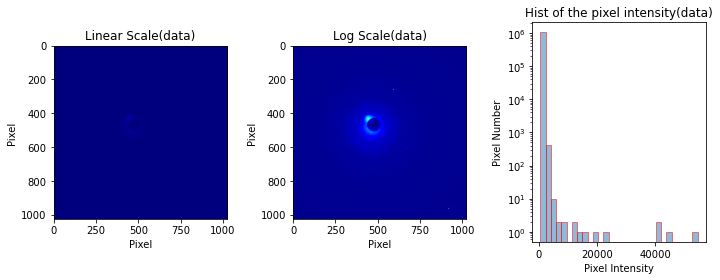

In [8]:
test=tf.imread(files[0]);
bkg_sign='no'
print('Load a image to check the signal level: '+files[0]);
print('Total number of images in the chosen directory is ' + str(len(files)));

# Load or not load the bkg signal
if bkg_sign == 'yes':
    print('Load background signal');
    data_bkg, bkg_ir, bkg_uv, _, bkg_counts, bkg_current = get_image_details_keV(bkg_files) # Load bkg images
    test_bkg = tf.imread(bkg_files[0])
    bkg_dlys_ave = np.nanmean(data_bkg,axis=0) # averaging all the images to optain one image

# Plot a testing figure and check the intensity
plt.figure(figsize=(10,4))

if bkg_sign == 'yes': # Plot both the data and the background images
    plt.subplot(2,3,1);
    plt.imshow(test,cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(2,3,2);
    plt.imshow(np.log(test),cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(2,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
    
    plt.subplot(2,3,4);
    plt.imshow(test_bkg,cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(bkg)')
    
    plt.subplot(2,3,5);
    plt.imshow(np.log(test_bkg),cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(bkg)')
    
    plt.subplot(2,3,6);
    plt.hist(test_bkg.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(bkg)');
    plt.yscale('log')
    
else:
    plt.subplot(1,3,1);
    plt.imshow(test,cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(1,3,2);
    plt.imshow(np.log(test),cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(1,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
plt.tight_layout()
plt.show()

tf.imwrite("Raw_data_ex.tif", test)

### Reading in All Data and Getting Total Counts -- Lauren's Version

In [21]:
%%time


print('Load diffraction signal');
#test_data, stage_positions, file_numbers, counts = get_image_details_ontph(files[:20], sort=True)
#test_data, ir_stage, uv_stage, file_numbers, counts, current = get_image_details_keV(files[:])
uni_stage_ir = np.unique(ir_stage)# Pump-probe stage position
uni_stage_uv = np.unique(uv_stage)

if len(uni_stage_ir) > 1: 
    stage_positions = ir_stage
elif len(uni_stage_uv) > 1: 
    stage_positions = uv_stage
else:
    print("Bad Stage Positions")
#good_range = np.concatenate((np.arange(0, 2500, 1), np.arange(2800, 3300, 1)))
#good_range = np.concatenate((np.arange(0, 250, 1), np.arange(500, 750, 1)))
good_range = np.arange(0, 5000, 1)
filter_data = 'no'
ref_sign = 'no'



if filter_data == 'yes':
    test_data = test_data[good_range]
    stage_positions = stage_positions[good_range]
    counts = counts[good_range]
    file_numbers = file_numbers[good_range]
    
if ref_sign == 'yes':
    ref_data, ref_ir, ref_uv, ref_files, ref_counts, ref_current = get_image_details_keV(ref_files)
    ref_stage = np.zeros(len(ref_data))
    stage_positions = np.concatenate((stage_positions, ref_stage))
    test_data = np.concatenate((test_data, ref_data))
    counts = np.concatenate((counts, ref_counts))
    current = np.concatenate((current, ref_current))
    
if bkg_sign == 'yes':
    test_data = test_data - bkg_dlys_ave

counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position


print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))
#print(file_numbers)

Load diffraction signal
['Delay', '007', '110.1700']
['Delay', '006', '108.7800']
['Delay', '022', '108.0100']
['Delay', '026', '108.9700']
['Delay', '032', '108.0000']
['Delay', '018', '108.6200']
['Delay', '015', '111.6700']
['Delay', '019', '108.6000']
['Delay', '002', '108.9100']
['Delay', '029', '108.7500']
['Delay', '030', '108.7000']
['Delay', '031', '108.7200']
['Delay', '003', '108.6800']
['Delay', '025', '116.1700']
['Delay', '034', '108.7600']
['Delay', '013', '108.6700']
['Delay', '010', '108.7700']
['Delay', '027', '108.8100']
['Delay', '023', '108.8200']
['Delay', '017', '109.2000']


NameError: name 'ir_stage' is not defined

### Visualizing Data Info

NameError: name 'counts' is not defined

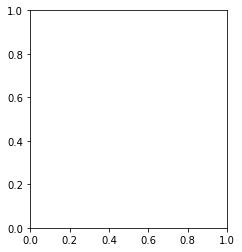

In [10]:
fig = plt.figure(figsize = (12,4)) # Plot counts rate, images number at each posi, and bad images

plt.subplot(1,3,1)
plt.plot(counts,'d')
plt.axhline(y = counts_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts');

plt.subplot(1,3,2) # Histogram the number of images at each posi
plt.plot(uni_stage,'-o');
plt.xlabel('pp stage posi');
plt.ylabel('Stg Position [mm]');
plt.title('Delay Stage Position');

plt.subplot(1,3,3) # Histogram the number of images at each posi
posi_edges_bins = np.append(uni_stage-0.001,uni_stage[-1])
posi_hist,posi_edges = np.histogram(stage_positions,bins=posi_edges_bins)
plt.plot(uni_stage,posi_hist,'-*')
plt.xlabel('pp stage posi [mm]');
plt.ylabel('Num of Imges');
plt.title('Num of images at each delay');

plt.tight_layout()
plt.show()

## Filtering Out Bad Shots Based on Total Counts

Either remove shots based on the standard deviation of the total counts or manually select which files to remove based on the image number.  
Based on location of "good" shots. 

In [530]:
# Decide to use threshold or selected images
#test_data = good_data
remove_std = False
if remove_std is True:
    # Auto find out the bad images by filtering on the total counts
    tc_good = np.squeeze(np.where(abs(counts-counts_mean)<3*counts_std)) # Find out the indices of the low counts images
    good_data = test_data[tc_good]
    good_stage = stage_positions[tc_good]
    good_counts = counts[tc_good]
    #good_files = file_numbers[tc_good]
    
elif remove_std is False:
    good_data = test_data
    good_stage = stage_positions
    good_counts = counts
# else:
#     # Manual find out the bad images by checking the tc from last figure
#     tc_good = np.concatenate((np.arange(0, 923, 1), np.arange(926, 1319, 1), np.arange(1322, 2113, 1), np.arange(2261, len(test_data), 1)))
#     good_data=test_data[tc_good]
#     good_stage = np.squeeze(stage_positions[tc_good])
#     good_counts = counts[tc_good]

print(len(good_data))



600


## Averaging Based on Image Number

In [12]:
grp_sz = 50
groups = np.arange(0, len(good_files)+1, grp_sz)
data = []
image_number = []
for i in range(len(groups)-1):
    ave_data = np.mean(good_data[groups[i]:groups[i+1]], axis=0)
    print("Averaging group: ", groups[i], "-", groups[i+1])
    data.append(ave_data)
    image_number.append(good_files[groups[i]])
    
data = np.array(data)
print(data.shape)

NameError: name 'good_files' is not defined

In [98]:
%%time

x_centers = []
y_centers = []
for i in range(len(data)):
    center = find_beam_center(data[i],center=[500,500],r=200)
    x_centers.append(center[0])
    y_centers.append(center[1])
    if i%1==0:
        print('Found center of ' + str(center)+' of group ' + str(i))
x_centers = np.array(x_centers)
y_centers = np.array(y_centers)
centers = x_centers, y_centers
x_ave = np.mean(x_centers[np.where(x_centers > 0)[0]])
y_ave = np.mean(y_centers[np.where(y_centers > 0)[0]])
x_centers[np.where(x_centers == 0)[0]] = x_ave
y_centers[np.where(y_centers == 0)[0]] = y_ave
center_ave = x_ave, y_ave
print(r'Averaged ctr is ' + str(center_ave))

Found center of [543, 506] of group 0
Found center of [543, 506] of group 1
Found center of [543, 506] of group 2
Found center of [544, 506] of group 3
Found center of [543, 506] of group 4
Found center of [543, 506] of group 5
Found center of [543, 506] of group 6
Found center of [543, 506] of group 7
Found center of [543, 506] of group 8
Found center of [543, 506] of group 9
Found center of [542, 506] of group 10
Found center of [544, 506] of group 11
Found center of [543, 507] of group 12
Found center of [544, 506] of group 13
Found center of [543, 506] of group 14
Found center of [543, 506] of group 15
Found center of [543, 506] of group 16
Found center of [544, 506] of group 17
Found center of [543, 506] of group 18
Found center of [544, 506] of group 19
Found center of [544, 506] of group 20
Found center of [542, 506] of group 21
Found center of [544, 507] of group 22
Found center of [544, 506] of group 23
Found center of [544, 506] of group 24
Found center of [543, 506] of group

/tmp/ipykernel_3759929/654476627.py:7: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(np.mean(data, axis=0)));


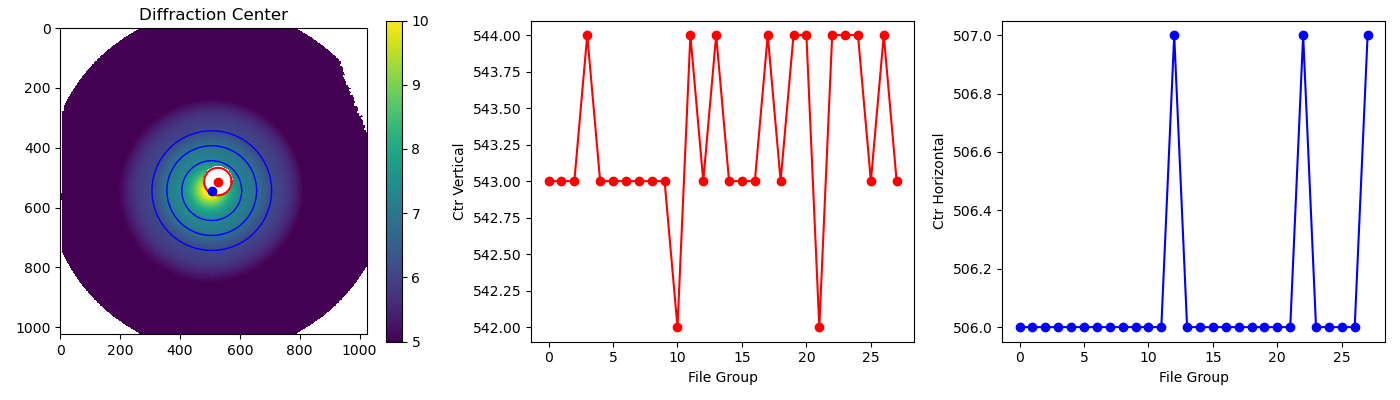

In [99]:
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)*hole[2]+hole[0];
y = np.sin(theta)*hole[2]+hole[1];
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(np.log(np.mean(data, axis=0)));
plt.colorbar()
plt.plot(x,y,'r',hole[0],hole[1],'or',center_ave[1],center_ave[0],'ob');
for i in range(3):
    x = np.cos(theta)*(i+2)*50+center_ave[1];
    y = np.sin(theta)*(i+2)*50+center_ave[0];
    plt.plot(x,y,linewidth=1,color='b');
plt.clim([5,10]);
plt.title('Diffraction Center')

plt.subplot(1,3,2)
plt.plot(centers[0],'-or');
plt.xlabel('File Group');
plt.ylabel('Ctr Vertical');

plt.subplot(1,3,3)
plt.plot(centers[1],'-ob');
plt.xlabel('File Group');
plt.ylabel('Ctr Horizontal');

plt.tight_layout()
plt.show();

In [100]:
X_CENTER = center_ave[0]
Y_CENTER = center_ave[1]
#X_CENTER = 539
#Y_CENTER = 505
GRID_SIZE = 1024

pointer = np.empty((1024,1024))
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pointer[i,j]=int(np.sqrt((i-X_CENTER)**2+(j-Y_CENTER)**2))
img_r_max = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER))
x=[];y=[]
for ri in range(img_r_max):
    [X_temp,Y_temp]=np.where(pointer==ri)
    x.append(X_temp)
    y.append(Y_temp)
print(r'max Q index is ' + str(img_r_max));
r_max=len(x)

azi_data = get_azimuthal_average(data, x, y)

max Q index is 480


/tmp/ipykernel_3759929/1622898995.py:62: RuntimeWarning: Mean of empty slice
  ave=np.nanmean(I_r)
/tmp/ipykernel_3759929/1622898995.py:65: RuntimeWarning: Mean of empty slice
  I[ri]=np.nanmean(I_r)


/tmp/ipykernel_3759929/3505263159.py:242: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data, axis=0)


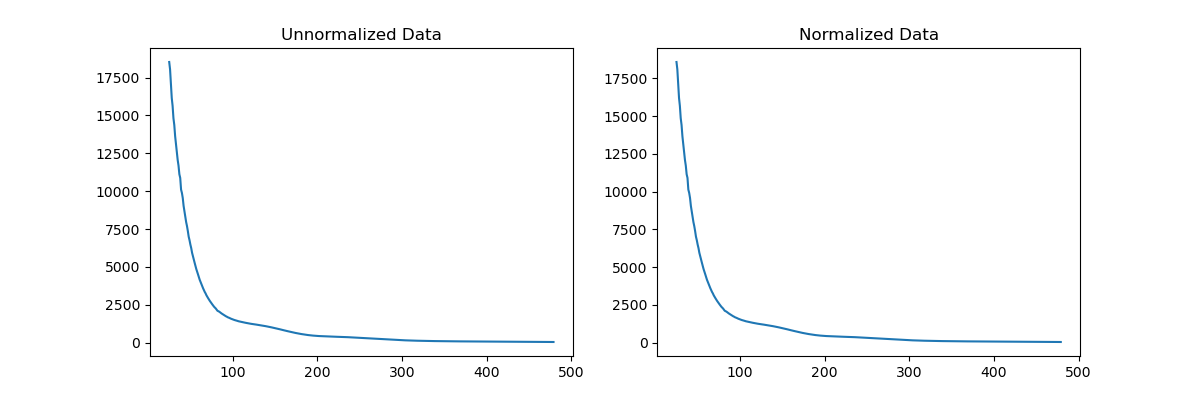

In [101]:
norm_data = normalize_to_baseline(azi_data) 

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(azi_data[0])
plt.title("Unnormalized Data")

plt.subplot(1,2,2)
plt.plot(norm_data[0])
plt.title("Normalized Data")
plt.show()

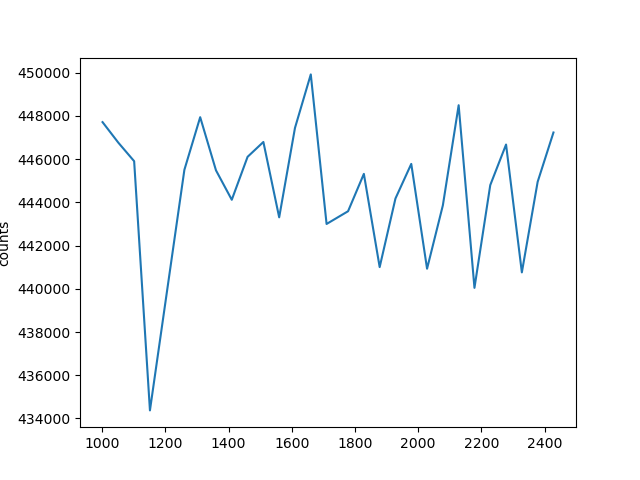

In [102]:
low_q = []
for i in range(len(norm_data)):
    q = np.sum(norm_data[i, 25:100])
    low_q.append(q)
    
low_q = np.array(low_q)

plt.figure()
plt.plot(image_number, low_q)
plt.ylabel("counts")
plt.show()

## Averaging Based on Delay Position

In [531]:
good_data.shape

(600, 1024, 1024)

In [532]:
%%time
stage_len = len(uni_stage);               #  Number of delays
stage_ave = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images
stage_ave_mk = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images with mask
current_ave = []
if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print('Averaging data at stage posi # '+ str(i) + ', ' + str(uni_stage[i]) + ' mm') # Obtain a sub array to save the data in one delay
    stage_data = good_data[np.where(good_stage==uni_stage[i])[0]];
    curr_ave = np.mean(current[np.where(good_stage==uni_stage[i])[0]], axis=0)
    current_ave.append(curr_ave)
    stage_ave[i] = np.nanmean(stage_data,axis=0); # no subtracting background
    #stage_ave[i][stage_ave[i]<0] = 0; # make negative values to 0 
    


Averaging data at stage posi # 0, 0.0 mm
Averaging data at stage posi # 5, 26.795 mm
Averaging data at stage posi # 10, 26.8325 mm
Averaging data at stage posi # 15, 26.87 mm
Averaging data at stage posi # 20, 26.9075 mm
Averaging data at stage posi # 25, 26.945 mm
CPU times: user 815 ms, sys: 458 ms, total: 1.27 s
Wall time: 1.27 s


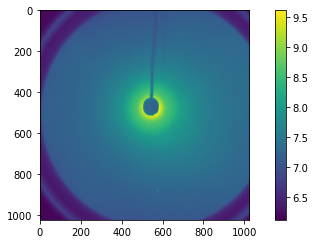

In [533]:
plt.figure()
plt.imshow(np.log(stage_ave[0]))
plt.colorbar()
plt.show()

## Generate Background Based on Corners -- After Averaging

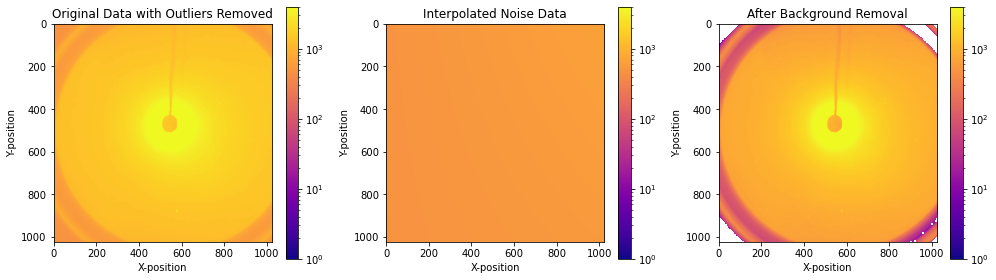

In [534]:
mean_data = np.mean(stage_ave, axis = 0)
std_data = np.std(stage_ave, axis = 0)

noise_data = backgroundNoise(mean_data)
noiseless_data = backgroundNoise(mean_data, remove_noise = True)

sub_edges = 'Yes'
if sub_edges =='Yes':
    stage_ave = stage_ave- noise_data
    good_counts = get_counts(stage_ave)

    
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
vmin_1_1, vmax_1_1 = 10**-0, 4000 

#Before
img1 = axes[0].imshow(mean_data, cmap='plasma', norm=matplotlib.colors.LogNorm(vmin=vmin_1_1, vmax=vmax_1_1))
axes[0].set_title('Original Data with Outliers Removed')
axes[0].set_xlabel('X-position')
axes[0].set_ylabel('Y-position')
colorbar1 = fig.colorbar(img1, ax=axes[0])  # Add colorbar to the first subplot

#Noise
img2 = axes[1].imshow(noise_data, cmap='plasma',  norm=matplotlib.colors.LogNorm(vmin=vmin_1_1, vmax=vmax_1_1))  
# Use the same normalization as img1
axes[1].set_title('Interpolated Noise Data')
axes[1].set_xlabel('X-position')
axes[1].set_ylabel('Y-position')
colorbar2 = fig.colorbar(img2, ax=axes[1])  # Add colorbar to the second subplot

# Noise Removed
img3 = axes[2].imshow(noiseless_data, cmap='plasma',  norm=matplotlib.colors.LogNorm(vmin=vmin_1_1, vmax=vmax_1_1))  # Logarithmic scaling
axes[2].set_title('After Background Removal')
axes[2].set_xlabel('X-position')
axes[2].set_ylabel('Y-position')
colorbar3 = fig.colorbar(img3, ax=axes[2])  # Add colorbar to the third subplot


# img4 = axes[3].plot(good_counts, '-d')
# axes[3].set_xlabel('Image Number');
# axes[3].set_ylabel('Counts');



## Finding Diffraction Center -- After Averaging

Right now it is only worthwhile to run this on the stage averaged data as it takes a very long time. Ultimately will try to get working in parallel in order to find the center of each individual image. __Note:__ occasionally it returns a 0, 0 value for the centers. The average of all non-zero values are taken and then each zero is replaced with the average center. Test this vs lab time.

In [535]:
stage_ave.shape

(30, 1024, 1024)

In [536]:
%%time

x_centers = []
y_centers = []
for i in range(len(stage_ave)):
    center = find_beam_center(stage_ave[i],center=[500,500],r=125)
    x_centers.append(center[0])
    y_centers.append(center[1])
    if i%1 == 0:
        print('Found center of ' + str(center)+' stage_position ' + str(uni_stage[i]))
x_centers = np.array(x_centers)
y_centers = np.array(y_centers)
centers = x_centers, y_centers
x_ave = np.mean(x_centers[np.where(x_centers > 0)[0]])
y_ave = np.mean(y_centers[np.where(y_centers > 0)[0]])
x_centers[np.where(x_centers == 0)[0]] = x_ave
y_centers[np.where(y_centers == 0)[0]] = y_ave
center_ave = x_ave, y_ave
print(r'Averaged ctr is ' + str(center_ave))

Found center of [485.3344503129271, 556.3337817225419] stage_position 0.0
Found center of [486.69706954364136, 557.1109411248639] stage_position 26.765
Found center of [487.65948470835565, 560.4939656238477] stage_position 26.7725
Found center of [0, 0] stage_position 26.78
Found center of [487.0687873462906, 557.9288428761255] stage_position 26.7875
Found center of [485.1732420120607, 554.8859516807952] stage_position 26.795
Found center of [487.3377494737506, 557.345749581298] stage_position 26.8025
Found center of [485.47571385204344, 555.5825997335617] stage_position 26.81
Found center of [485.5033134112193, 557.0414250090677] stage_position 26.8175
Found center of [484.7457225164948, 554.5593498423531] stage_position 26.825
Found center of [487.35496338645504, 559.4902758980403] stage_position 26.8325
Found center of [486.6451398615337, 557.5788876024726] stage_position 26.84
Found center of [486.448042843453, 558.5430936829574] stage_position 26.8475
Found center of [485.86582557

In [537]:
# (1) Hole mask: Define mask of the hole
data_ave_raw = np.mean(stage_ave,axis=0); # Mean data of all the images
data_ave     = np.copy(data_ave_raw) #[200:900,200:900]
image_array  = np.log(data_ave)/np.nanmax(np.log(data_ave))
image_array  *=255
im = Image.fromarray(image_array)
im = im.convert('L')
im = np.array(im)

# Mask hole and Finding the diffraction center
hole = np.squeeze(cv2.HoughCircles(im, cv2.HOUGH_GRADIENT_ALT, 1.5, 32, param1=50, param2=0.8, minRadius=30, maxRadius=50))
mask = np.ones((1024,1024)) # Hole mask
y_m,x_m = np.ogrid[:1024,:1024];
mask[((x_m-hole[0])**2 + (y_m-hole[1])**2 <= (hole[2]+5)**2)] = np.nan;# Create a circular mask filled with nans inside the circle
print('The hole center at ' + str(hole[0:2]) + ' with radius ' + str(hole[2:3]));
#stage_ave = stage_ave*mask
#good_data = good_data*mask

The hole center at [540.  463.5] with radius [37.374676]


<ipython-input-537-1ef51bf286f9>:4: RuntimeWarning: invalid value encountered in log
  image_array  = np.log(data_ave)/np.nanmax(np.log(data_ave))


<ipython-input-538-602b5fc6de4a>:7: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(np.mean(stage_ave, axis=0)));


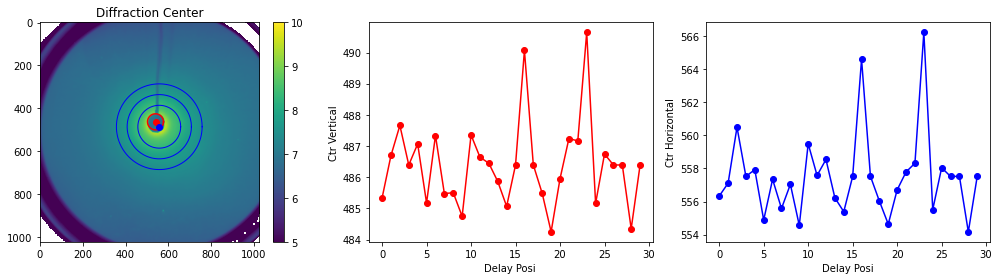

In [538]:
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)*hole[2]+hole[0];
y = np.sin(theta)*hole[2]+hole[1];
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(np.log(np.mean(stage_ave, axis=0)));
plt.colorbar()
plt.plot(x,y,'r',hole[0],hole[1],'or',center_ave[1],center_ave[0],'ob');
for i in range(3):
    x = np.cos(theta)*(i+2)*50+center_ave[1];
    y = np.sin(theta)*(i+2)*50+center_ave[0];
    plt.plot(x,y,linewidth=1,color='b');
plt.clim([5,10]);
plt.title('Diffraction Center')

plt.subplot(1,3,2)
plt.plot(centers[0],'-or');
plt.xlabel('Delay Posi ');
plt.ylabel('Ctr Vertical');

plt.subplot(1,3,3)
plt.plot(centers[1],'-ob');
plt.xlabel('Delay Posi');
plt.ylabel('Ctr Horizontal');

plt.tight_layout()
plt.savefig((image_path + 'Center Info' + today))
plt.show();

## Masking Beam Block -- After Averaging

### Find Mask Location

(540.0, 475.0)
(30, 1024, 1024)


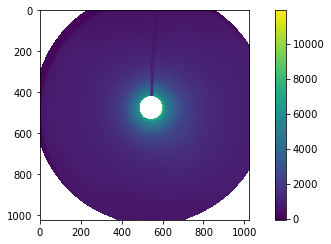

In [539]:
#hole_center = (477.0, 465.0)
hole = (540.0, 475.0, 50.0)
hole_center = hole[0], hole[1]
print(hole_center)
inner_radius = float(hole[2])
outer_radius = 575
data_ave_raw = np.mean(stage_ave,axis=0); 
ring_mask_data = detectorMask(stage_ave, hole_center, inner_radius, outer_radius, plot_image = True)
ring_mask_ave = np.mean(ring_mask_data, axis = 0)
print(ring_mask_data.shape)

<ipython-input-540-438465d843f4>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(x, y, np.log(ring_mask_ave[300:700, 300:700]))


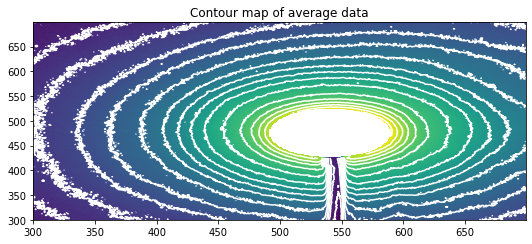

In [540]:
import matplotlib.cm as cm
x = np.arange(300, 700)
y = np.arange(300, 700)
X, Y = np.meshgrid(y, x)
fig, ax= plt.subplots()
ax.pcolormesh(x, y, np.log(ring_mask_ave[300:700, 300:700]))
CS = ax.contour(X, Y, np.log(ring_mask_ave[300:700, 300:700]), levels = 20, colors='w')
ax.set_title('Contour map of average data')

stage_ave = ring_mask_data

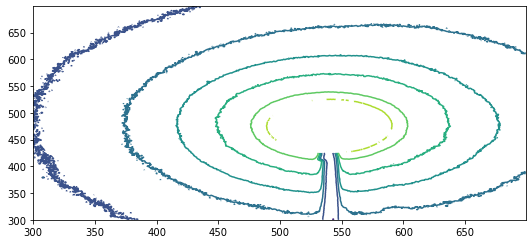

In [221]:
# import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

# x = [1, 2, 3, 4]
# y = [1, 2, 3, 4]
# m = [[15, 14, 13, 12], [14, 12, 10, 8], [13, 10, 7, 4], [12, 8, 4, 0]]

# cs = plt.contour(X, Y, np.log(ring_mask_ave[300:700, 300:700]))

# data_x = []
# data_y = []
# for item in cs.collections:
#     for i in item.get_paths():
#         v = i.vertices
#         x = v[:, 0]
#         y = v[:, 1]
#         data_x.append(np.array(x))
#         data_y.append(np.array(y))
#         #print(x, y)
# plt.show()
# data_x = np.array(data_x)
# data_y = np.array(data_y)

# # print(data_x)
# # print(data_y)

# import circle_fit as cf
# for i in range(len(data_x)):
#     xc,yc,r,_ = cf.least_squares_circle((data_x[i], data_y[i]))
#     print(xc, yc)
# print(x)

### Add Additional Mask

(29, 1024, 1024)


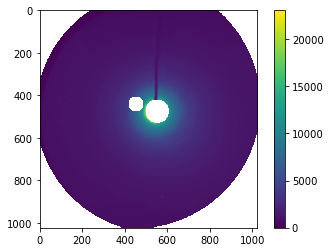

In [210]:
hole_center = (450, 440)
inner_radius = 30
outer_radius = 590
data_ave_raw = np.mean(ring_mask_data,axis=0); 
ring_mask_data = detectorMask(ring_mask_data, hole_center, inner_radius, outer_radius, plot_image = True)
ring_mask_ave = np.mean(ring_mask_data, axis = 0)
print(ring_mask_data.shape)

### Add Rectangular Mask

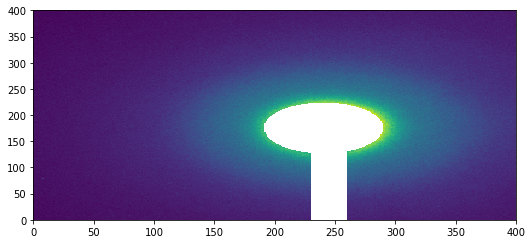

In [541]:
mask_rec = np.empty((450,30))
mask_rec[:, :] = np.nan

ring_mask_data[:, 0:450, 530:560] = ring_mask_data[:, 0:450, 530:560]*mask_rec
plt.figure()
plt.pcolor(ring_mask_data[0,300:700,300:700])
plt.show()

## Clean After Averaging

Here, we utilize a masked array to create nan values for each entry outside of the standard deviation threshold. In this way, we eliminate the need for inputting NaN values, as these are stored as a Boolean.

In [542]:
%%time

#clean_data = cleanMean(test_data)
#counts_clean = get_counts(clean_data)
clean_data = clean_and_filter(stage_ave)
clean_data = np.array(clean_data)
counts_clean = get_counts(clean_data)

counts_clean_mean = np.nanmean(counts_clean)
counts_clean_std = np.nanstd(counts_clean)

Cleaning data
CPU times: user 3.49 s, sys: 115 ms, total: 3.61 s
Wall time: 3.61 s


<timed exec>:7: RuntimeWarning: Mean of empty slice
/home/centurion/lheald2/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<ipython-input-543-e0a8f3a6babb>:23: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(clean_data[0]));


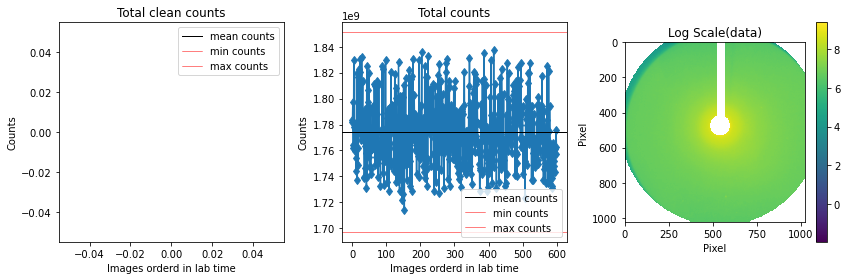

In [543]:
fig = plt.figure(figsize = (12,4))
plt.subplot(1, 3, 1)
plt.plot(counts_clean,'-d')
plt.axhline(y = counts_clean_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_clean_mean-(3*counts_clean_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_clean_mean+(3*counts_clean_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total clean counts');

plt.subplot(1, 3, 2)
plt.plot(counts,'-d')
plt.axhline(y = np.mean(counts), color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*np.std(counts)), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*np.std(counts)), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts')

plt.subplot(1, 3, 3)
plt.imshow(np.log(clean_data[0]));
plt.colorbar()
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('Log Scale(data)')

plt.show()

## Removing Radial Outliers -- BETA (WORKS! but slow)

Runs the function `remove_radial_outliers` which takes in a 1024, 1024 image and generates the radial average of that image. Then it compares each point at that radial distance with the mean to a threshhold value of 3 standard deviations from the mean. If the pixel value falls outside of the threshhold range, the average radial value is swapped in. 

__Notes:__ 
 - Requires global variables of `X_CENTER`, `Y_CENTER`, and `GRID_SIZE` 
 - Currently runs very slowly. Will work on running it in parallel eventually
 - Try starting radial values at 1 instead of zero to remove runtime warning
 - Need to add additional mask eventually as this exaggerates bright spot in the data

In [214]:
%%time
stage_ave = np.nan_to_num(stage_ave)
X_CENTER = center_ave[0]
Y_CENTER = center_ave[1]
GRID_SIZE = 1024
# azi_data = []
# for image in stage_ave:
#     data, _ = get_radial_distribution(image) # Function of averaging
#     azi_data.append(data)
    
    
# azi_data = np.array(azi_data)
# print(azi_data.shape)

cleaned_data = []
for image in stage_ave:
    clean_image = remove_radial_outliers(image)
    cleaned_data.append(clean_image)

cleaned_data = np.array(cleaned_data)


CPU times: user 3min 3s, sys: 2.65 s, total: 3min 5s
Wall time: 3min 6s


/tmp/ipykernel_2772609/277139372.py:6: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(stage_ave[0]))
/tmp/ipykernel_2772609/277139372.py:6: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(stage_ave[0]))
/tmp/ipykernel_2772609/277139372.py:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(cleaned_data[0]))


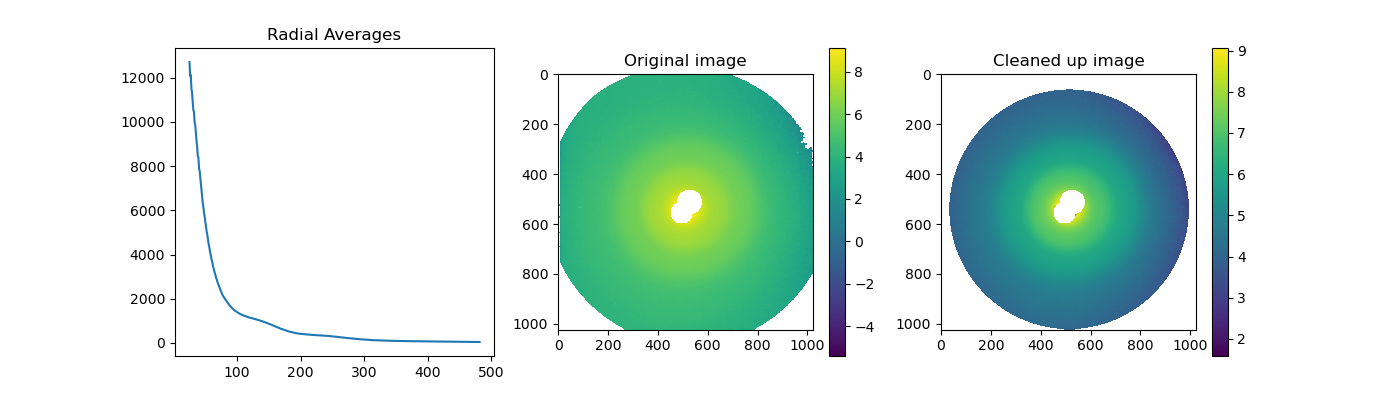

In [215]:
plt.figure(figsize=(14,4))
plt.subplot(1, 3, 1)
plt.plot(azi_data[0])
plt.title("Radial Averages")
plt.subplot(1, 3, 2)
plt.imshow(np.log(stage_ave[0]))
plt.colorbar()
plt.title("Original image")
plt.subplot(1,3,3)
plt.imshow(np.log(cleaned_data[0]))
plt.colorbar()
plt.title("Cleaned up image")
plt.show()

stage_ave = cleaned_data
del cleaned_data

## Azimuthal Averaging -- SLAC Way

In [544]:
X_CENTER = center_ave[0]
Y_CENTER = center_ave[1]
#X_CENTER = 539
#Y_CENTER = 505
GRID_SIZE = 1024

pointer = np.empty((1024,1024))
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pointer[i,j]=int(np.sqrt((i-X_CENTER)**2+(j-Y_CENTER)**2))
img_r_max = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER))
x=[];y=[]
for ri in range(img_r_max):
    [X_temp,Y_temp]=np.where(pointer==ri)
    x.append(X_temp)
    y.append(Y_temp)
print(r'max Q index is ' + str(img_r_max));
r_max=len(x)

azi_data = get_azimuthal_average(stage_ave, x, y)

max Q index is 466


<ipython-input-6-850f521fab82>:62: RuntimeWarning: Mean of empty slice
  ave=np.nanmean(I_r)
/home/centurion/lheald2/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-6-850f521fab82>:65: RuntimeWarning: Mean of empty slice
  I[ri]=np.nanmean(I_r)


## Normalize Azimuthal Averages to Baseline

<ipython-input-3-5c78cb28d842>:242: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data, axis=0)


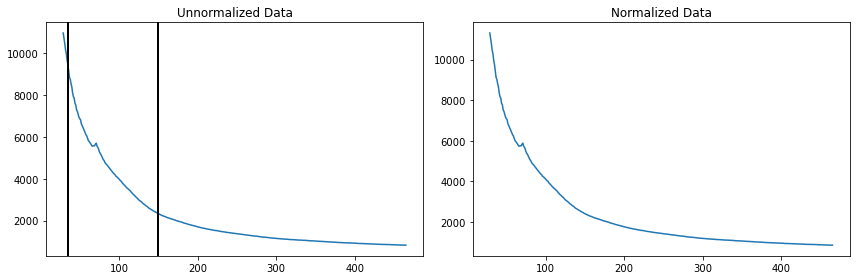

In [545]:
min_edge = 35
max_edge = 150
norm_data = normalize_to_baseline(azi_data, min_edge, max_edge) 

# (3) Plot the figure: Plot the time-dependent signal
angs = '\u00C5'; # angstrom sign
s_cali = 0.026 # S calibration in experiment
#posi_0    = 154.405 # The reference T0
#posi_0 = 208.85
#posi_0 = 74.9
posi_0 = 26.85
s = np.arange(0,len(azi_data[0]))*s_cali # The Q axis
realtime = -(uni_stage-posi_0)/0.15  # Delay axis in ps

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(azi_data[0])
plt.axvline(x = min_edge, color = 'k', linestyle = '-',linewidth=2);
plt.axvline(x = max_edge, color = 'k', linestyle = '-',linewidth=2);
plt.title("Unnormalized Data")

plt.subplot(1,2,2)
plt.plot(norm_data[0])
plt.title("Normalized Data")
plt.savefig(image_path + 'Normalization' + today)
plt.show()

## Plotting the Time-Dependent Signal

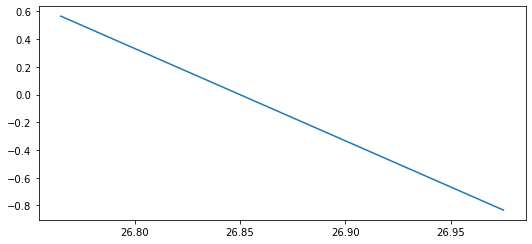

[ 0.     26.765  26.7725 26.78   26.7875 26.795  26.8025 26.81   26.8175
 26.825  26.8325 26.84   26.8475 26.855  26.8625 26.87   26.8775 26.885
 26.8925 26.9    26.9075 26.915  26.9225 26.93   26.9375 26.945  26.9525
 26.96   26.9675 26.975 ]
[ 1.79000000e+02  5.66666667e-01  5.16666667e-01  4.66666667e-01
  4.16666667e-01  3.66666667e-01  3.16666667e-01  2.66666667e-01
  2.16666667e-01  1.66666667e-01  1.16666667e-01  6.66666667e-02
  1.66666667e-02 -3.33333333e-02 -8.33333333e-02 -1.33333333e-01
 -1.83333333e-01 -2.33333333e-01 -2.83333333e-01 -3.33333333e-01
 -3.83333333e-01 -4.33333333e-01 -4.83333333e-01 -5.33333333e-01
 -5.83333333e-01 -6.33333333e-01 -6.83333333e-01 -7.33333333e-01
 -7.83333333e-01 -8.33333333e-01]


In [546]:
plt.figure()
plt.plot(uni_stage[1:], realtime[1:])
plt.show()
print(uni_stage)
print(realtime)

## Find T0

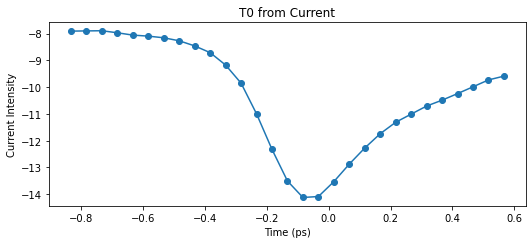

In [547]:
current_ave = np.array(current_ave)
current_norm = current_ave/np.min(current_ave)

H0 = 0.1
A0 = 1.0
x0 = 26.7
sigma0 = 0.1
guess = [H0, A0, x0, sigma0]


def func(x, a, x0, sigma): 
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) 
#Define the Gaussian function 
def gauss(x, H, A, x0, sigma): 
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))


# parameters, covariance = curve_fit(func, uni_stage[3:-3], current_norm[3:-3]) 
  
# fit_A = parameters[0] 
# fit_B = parameters[1] 
  
# fit_y = Gauss(uni_stage, fit_A, fit_B) 
plt.figure()
plt.plot(realtime[1:], current_ave[1:], '-o', label='data') 
#plt.plot(uni_stage, fit_y, '-', label='fit') 
plt.xlabel("Time (ps)")
plt.ylabel("Current Intensity")
plt.title("T0 from Current")
plt.savefig((image_path + '/T0_current' + today))
plt.show()


## Plot Time Resolved Signal

<ipython-input-548-20f3d4f72fa1>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(s,realtime[1:],dI_I_norm[1:],cmap='jet');
/util/opt/anaconda/deployed-conda-envs/packages/python/envs/python-3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:2141: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


26


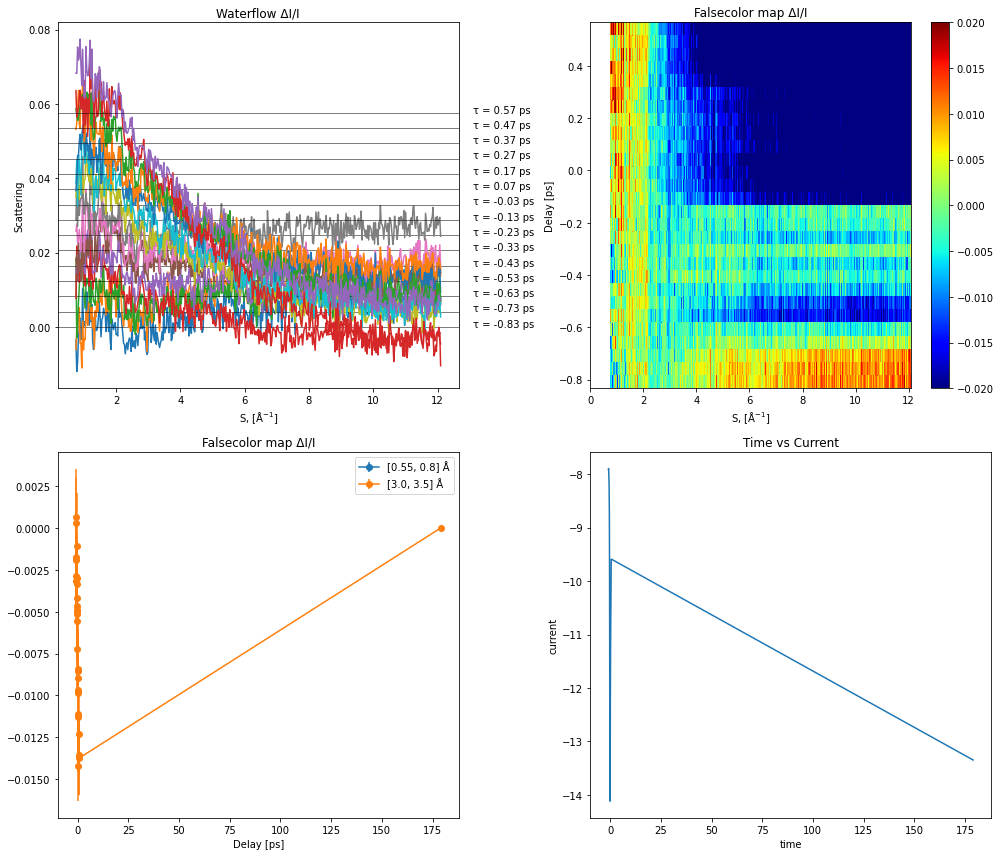

In [548]:

if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 5
#ref_sign = 'yes'
if ref_sign == 'yes':
    norm_ref = norm_data[0] 
else:
    #norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0
    norm_ref = np.nanmean(norm_data[-N_ref:], axis=0)

dI_I_norm = (norm_data[:]-norm_ref)/norm_ref; # Calculate the percentage difference signal
# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
for i in range(stage_len):
    if i%2 == 0:
        plt.plot(s,dI_I_norm[stage_len-i-1] + np.nanmax(dI_I_norm)*(i)/10);
        plt.text(s[-1]+1,np.nanmax(dI_I_norm)*(i)/10, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
        plt.axhline(y = np.nanmax(dI_I_norm)*(i)/10, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Scattering');plt.title('Waterflow ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s,realtime[1:],dI_I_norm[1:],cmap='jet');
plt.clim(vmin=-0.02, vmax=0.02);
plt.colorbar()
#plt.xlim(0.5, 5)
#plt.ylim(-3, 15)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,3)
RoI_1 = [0.55, 0.8];
RoI_2 = [3.0, 3.5];
print(round(RoI_1[0]/0.0215))
Inte_1 = dI_I_norm[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = dI_I_norm[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1);
Inte_2 = dI_I_norm[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
std_2 = dI_I_norm[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1);
#plt.errorbar(realtime,Inte_1,'-*', yerr=std_1, linewidth=3, label=str(RoI_1)+' '+angs);
#plt.errorbar(realtime,Inte_2,'-*', yerr=std_2, linewidth=3, label=str(RoI_2)+' '+angs);
plt.errorbar(realtime,Inte_1, yerr=std_1,  fmt='-o',  label=str(RoI_1)+' '+angs);
plt.errorbar(realtime,Inte_2, yerr=std_2,  fmt='-o', label=str(RoI_2)+' '+angs);
#plt.errorbar(realtime,Inte_3, yerr=std_3,  fmt='-o', label=str(RoI_2)+' '+angs);
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,4)
plt.plot(realtime, current_ave)
plt.title("Time vs Current")
plt.xlabel("time")
plt.ylabel("current")

plt.tight_layout()
plt.savefig((image_path + 'Raw Data'))
plt.show()

# plt.tight_layout()
# plt.show()

### Checking total counts

38


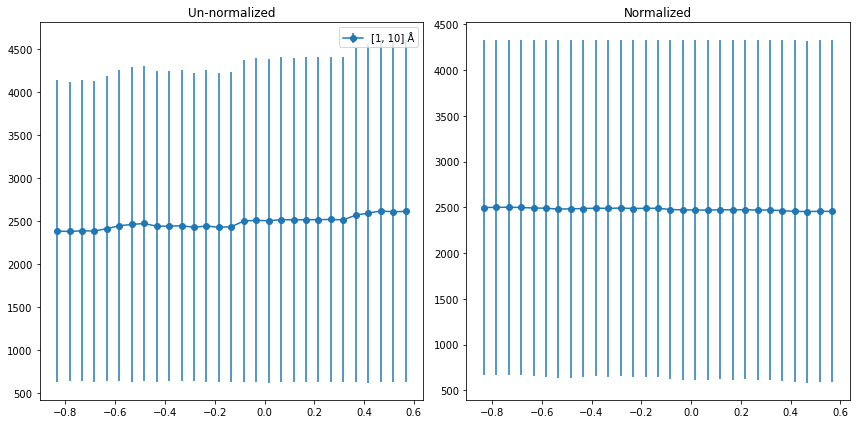

In [549]:

RoI_1 = [1, 10];
RoI_2 = [3.0, 3.5];
print(round(RoI_1[0]/s_cali))
Inte_1 = azi_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = azi_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1);

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
#plt.errorbar(realtime,Inte_1,'-*', yerr=std_1, linewidth=3, label=str(RoI_1)+' '+angs);
#plt.errorbar(realtime,Inte_2,'-*', yerr=std_2, linewidth=3, label=str(RoI_2)+' '+angs);
plt.errorbar(realtime[1:],Inte_1[1:], yerr=std_1[1:],  fmt='-o',  label=str(RoI_1)+' '+angs);
#plt.errorbar(realtime,Inte_2, yerr=std_2,  fmt='-o', label=str(RoI_2)+' '+angs);
#plt.errorbar(realtime,Inte_3, yerr=std_3,  fmt='-o', label=str(RoI_2)+' '+angs);
#plt.xlim(-0.7,1)
plt.title("Un-normalized")
plt.legend()

Inte_1 = norm_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = norm_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1);

plt.subplot(1,2,2)
plt.errorbar(realtime[1:],Inte_1[1:], yerr=std_1[1:],  fmt='-o',  label=str(RoI_1)+' '+angs);
plt.title("Normalized")
plt.savefig(image_path + 'total counts')
plt.show()
    
#plt.xlim(-0.7,1)

## Power Fitting

In [550]:

corrected_dI, baseline2d = power_fit(dI_I_norm, s, degree = 2, return_baseline=True)
dI_I_ave = np.nanmean(dI_I_norm, axis=0)
corrected_ave = np.nanmean(corrected_dI, axis=0)
baseline_ave = np.nanmean(baseline2d, axis=0)

<ipython-input-550-4a3fe4a3277a>:2: RuntimeWarning: Mean of empty slice
  dI_I_ave = np.nanmean(dI_I_norm, axis=0)
<ipython-input-550-4a3fe4a3277a>:3: RuntimeWarning: Mean of empty slice
  corrected_ave = np.nanmean(corrected_dI, axis=0)


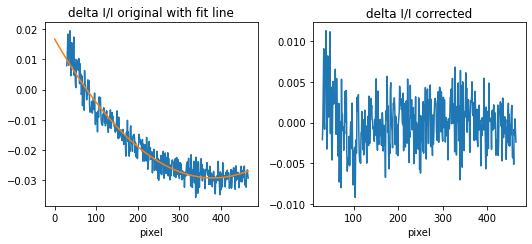

In [551]:
example = 7
plt.figure()
plt.subplot(1,2,1)
plt.plot(dI_I_norm[example])
plt.plot(baseline2d[example])
plt.xlabel("pixel")
plt.title("delta I/I original with fit line")

plt.subplot(1,2,2)
plt.plot(corrected_dI[example])
plt.xlabel("pixel")
plt.title("delta I/I corrected")
plt.show()

### Fit High S

In [511]:
s_range = np.arange(200, 480, 1)
corrected_dI, baseline2d = fit_high_s(dI_I_norm, s, s_range, return_baseline=True)
dI_I_ave = np.nanmean(dI_I_norm, axis=0)
corrected_ave = np.nanmean(corrected_dI, axis=0)
baseline_ave = np.nanmean(baseline2d, axis=0)

IndexError: index 469 is out of bounds for axis 0 with size 469

ValueError: x and y must have same first dimension, but have shapes (280,) and (479,)

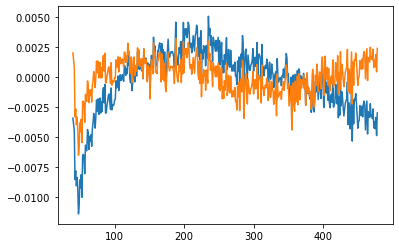

In [42]:
plt.figure()
plt.plot(dI_I_norm[10], label="orig")
plt.plot(corrected_dI[10], label="new")
plt.plot(s_range, baseline2d[10])
plt.legend()
#plt.plot(baseline2d[20])
plt.xlabel("pixel")
plt.title("delta I/I original with fit line")

plt.show()

plt.figure()
plt.plot(baseline2d[10])
plt.show()

### Plot with Error Bars

In [552]:
print(corrected_dI.shape)
print(s.shape)
print(uni_stage)

(30, 466)
(466,)
[ 0.     26.765  26.7725 26.78   26.7875 26.795  26.8025 26.81   26.8175
 26.825  26.8325 26.84   26.8475 26.855  26.8625 26.87   26.8775 26.885
 26.8925 26.9    26.9075 26.915  26.9225 26.93   26.9375 26.945  26.9525
 26.96   26.9675 26.975 ]


35


<ipython-input-553-a30122fd96ac>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(s,realtime[1:],corrected_dI[1:],cmap='jet');


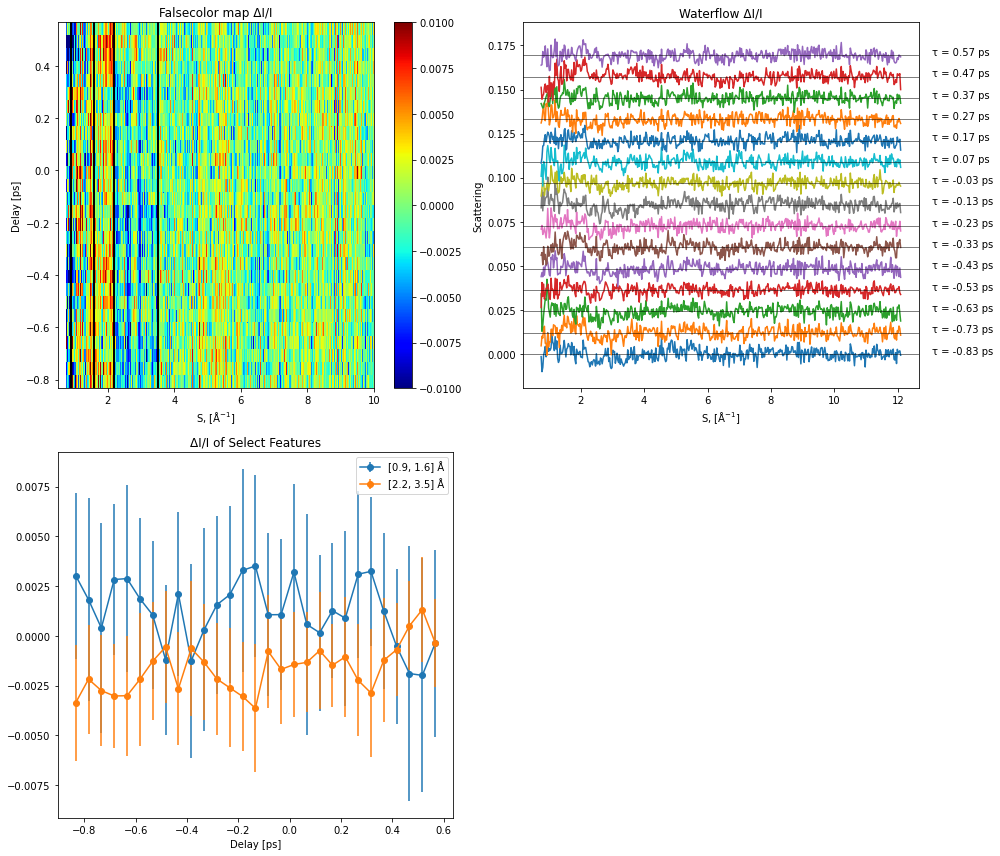

In [553]:
RoI_1 = [0.9, 1.6];
RoI_2 = [2.2, 3.5];
RoI_3 = [2.0, 2.6];
print(round(RoI_1[0]/s_cali))
Inte_1 = corrected_dI[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = corrected_dI[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1)
Inte_2 = corrected_dI[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
std_2 = corrected_dI[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1);
Inte_3 = corrected_dI[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].mean(axis=1);
std_3 = corrected_dI[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].std(axis=1);

plt.figure(figsize=(14,12))
plt.subplot(2,2,1)
plt.pcolor(s,realtime[1:],corrected_dI[1:],cmap='jet');
plt.axvline(x = RoI_1[0], color = 'k', linestyle = '-',linewidth=2);
plt.axvline(x = RoI_1[1], color = 'k', linestyle = '-',linewidth=2);
plt.axvline(x = RoI_2[0], color = 'k', linestyle = '-',linewidth=2);
plt.axvline(x = RoI_2[1], color = 'k', linestyle = '-',linewidth=2);
# plt.axvline(x = RoI_3[0], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_3[1], color = 'k', linestyle = '-',linewidth=1);
plt.clim(vmin=-0.01, vmax=0.01);
plt.colorbar()
#plt.ylim(-1, 15)
#plt.ylim(154.35, 154.6)
plt.xlim(0.5,10)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,2)
for i in range(stage_len):
    if i%2 == 0:
        plt.plot(s,corrected_dI[stage_len-i-1] + np.nanmax(corrected_dI)*(i)/3);
        plt.text(s[-1]+1,np.nanmax(corrected_dI)*(i)/3, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
        plt.axhline(y = np.nanmax(corrected_dI)*(i)/3, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Scattering');plt.title('Waterflow ΔI/I');

plt.subplot(2,2,3)
#plt.errorbar(realtime,Inte_1,'-*', yerr=std_1, linewidth=3, label=str(RoI_1)+' '+angs);
#plt.errorbar(realtime,Inte_2,'-*', yerr=std_2, linewidth=3, label=str(RoI_2)+' '+angs);
plt.errorbar(realtime[1:],Inte_1[1:], yerr=std_1[1:],  fmt='-o',  label=str(RoI_1)+' '+angs);
plt.errorbar(realtime[1:],Inte_2[1:], yerr=std_2[1:],  fmt='-o', label=str(RoI_2)+' '+angs);
#plt.errorbar(realtime,Inte_3, yerr=std_3,  fmt='-o', label=str(RoI_2)+' '+angs);
#plt.xlim(-1, 7)
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('ΔI/I of Select Features')
plt.savefig((image_path + 'Power fit data' + today))
plt.show()

## Fitting Rise Time

Uses a selected feature in the data to calculate a rise time based on the `scipy.special.erf()`

<ipython-input-554-29b330d3929b>:8: RuntimeWarning: Mean of empty slice
  earlydata = np.nanmean(corrected_dI[20:], axis=0)
<ipython-input-554-29b330d3929b>:9: RuntimeWarning: Mean of empty slice
  latedata = np.nanmean(corrected_dI[5:20], axis=0)


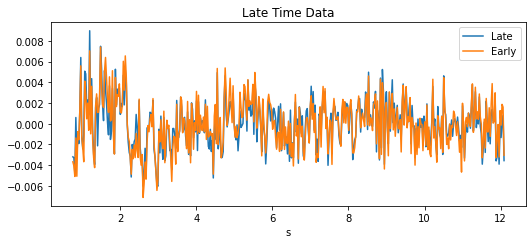

In [554]:
time1 =realtime
t0_1= Inte_1 - Inte_2
# t0_2 = Inte_2
data1 = corrected_dI
# s1 = s
# raw_data1 = good_data
# time1.shape
earlydata = np.nanmean(corrected_dI[20:], axis=0)
latedata = np.nanmean(corrected_dI[5:20], axis=0)
plt.figure()
plt.plot(s, latedata, label="Late")
plt.plot(s, earlydata, label="Early")
plt.title("Late Time Data")
plt.legend()
plt.xlabel("s")
plt.show()

In [45]:
realtime[-15:]

array([-0.1 , -0.15, -0.2 , -0.25, -0.3 , -0.35, -0.4 , -0.45, -0.5 ,
       -0.55, -0.6 , -0.65, -0.7 , -0.75, -0.8 ])

Fit parameters: 
t_0 = 0.2861  ps +-  0.0906  ps
FWHM =  1.2902 ps 0.3000 ps




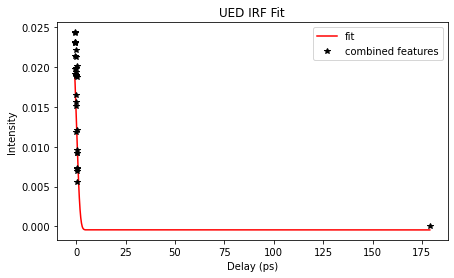

In [46]:
#Optimise

A = 0.01
t0 = 0.1
sigma = 0.5
offset = 0
x0 = [A, t0, sigma,offset]
# ## when fitting with an error function
import scipy
def equations(t, A, t0, sigma, offset): #def equations
    fit = A*(scipy.special.erf((t-t0)/(np.sqrt(2)*sigma)))+offset
    return fit

def erf_fit(t, A, t0, sigma, offset):
    fit = A* scipy.special.erf(((t-t0)/(sigma/(np.sqrt(2*np.log(2)))))*np.sqrt(2))+offset
    return fit 

# yo = equations(t, A, t0, sigma, offset) #equations
popt, pcov, id, _, _ = curve_fit(erf_fit, time1[:], t0_1[:], p0 = x0, maxfev = 5000000, method='lm',full_output=True)
t_new = np.linspace(realtime[0],realtime[-1],1000)
## error func fit
A, t0, sigma, offset = popt
print("Fit parameters: ")
print("=====================================================")

print("t_0 =", '%1.4f '%(popt[1]),'ps +- ','%1.4f '%np.sqrt(pcov[1,1]),"ps")
print("FWHM = ", '%1.4f'%(popt[2]), 'ps', '%1.4f' %np.sqrt(pcov[2,2]), "ps")

print("\n")
y_new = equations(t_new, *popt)
plt.figure(figsize=(7,4))
# plt.plot(t,yo,color=‘purple’,ls=‘--’)
plt.plot(t_new,y_new,color='red', label="fit")
plt.plot(time1, t0_1,'*',color='black', label="combined features")
#plt.xlim(-1,1)
#plt.ylim(-0.005, .01)
plt.xlabel("Delay (ps)")
plt.ylabel("Intensity")
plt.title("UED IRF Fit")
plt.legend()
plt.savefig(image_path + 'time fit')
plt.show()

## Save Data 

In [270]:
# np.savetxt("data_files/dI_s4_3000-4000_12-05-2023.txt", corrected)
# np.savetxt("data_files/s_s4_3000-4000_12-05-2023.txt", s)
# np.savetxt("data_files/realtime_s4_3000-4000_12-05-2023.txt", realtime)
# np.savetxt("data_files/stage_s4_3000-4000_12-05-2023.txt", uni_stage)

# np.savetxt("data_files/dI_s1_0-500_12-08-2023.txt", corrected_dI)
# np.savetxt("data_files/s_s1_0-500_12-08-2023.txt", s)
# np.savetxt("data_files/realtime_s1_0-500_12-08-2023.txt", realtime)
# np.savetxt("data_files/stage_s1_0-500_12-08-2023.txt", uni_stage)

# np.savetxt("data_files/dI_s1_500-1000_12-08-2023.txt", corrected_dI)
# np.savetxt("data_files/s_s1_500-1000_12-08-2023.txt", s)
# np.savetxt("data_files/realtime_s1_500-1000_12-08-2023.txt", realtime)
# np.savetxt("data_files/stage_s1_500-1000_12-08-2023.txt", uni_stage)

# np.savetxt("data_files/dI_s1_1000-1500_12-08-2023.txt", corrected_dI)
# np.savetxt("data_files/s_s1_1000-1500_12-08-2023.txt", s)
# np.savetxt("data_files/realtime_s1_1000-1500_12-08-2023.txt", realtime)
# np.savetxt("data_files/stage_s1_1000-1500_12-08-2023.txt", uni_stage)

# np.savetxt("data_files/dI_s1_1500-end_12-08-2023.txt", corrected_dI)
# np.savetxt("data_files/s_s1_1500-end_12-08-2023.txt", s)
# np.savetxt("data_files/realtime_s1_1500-end_12-08-2023.txt", realtime)
# np.savetxt("data_files/stage_s1_1500-end_12-08-2023.txt", uni_stage)

# np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/dI_0622_a.txt", dI_I_norm)
# np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/s_0622_a.txt", s)
# np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/realtime_0622_a.txt", realtime)
# np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/stage_0622_a.txt", uni_stage)
# np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/dI_corrected_0622_a.txt", corrected_dI)

np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/dI_2303_fast.txt", dI_I_norm)
np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/s_2303_fast.txt", s)
np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/realtime_2303_fast.txt", realtime)
np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/stage_2303_fast.txt", uni_stage)
np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/dI_corrected_2303_fast.txt", corrected_dI)

## Get PDF

### Getting Diffraction Scattering Signals

In [47]:
#Author: Keke Chen
#Contact: ckk20@mails.tsinghua.edu.cn

path_dcs= '/home/centurion/lheald2/GUED_Analysis/GUED_Analysis/packages/dcs_repository/3.7MeV/'
#path_dcs = '/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/'
table=pd.read_csv(path_dcs+'Periodic_Table.csv')
def import_s():
    """ This functions uses the C.dat files as an example file to generate values of s for the simulation calculations. 
    
    RETURNS:
    s (array) = array of s values which correspond to calculated scattering intensities for each atom.
    """
    
    qe=1.602176565e-19 
    me=9.10938291e-31
    c=299792458 
    h=6.62606957e-34
    E=3700000*qe+me*c**2 #kinetic energy=3.7MeV
    p=(E**2/c**2-me**2*c**2)**0.5
    lamb=h/p
    k=2*np.pi/lamb #wave vector of the incident electron

    path=path_dcs+'C.dat'
    with open(path,'r') as file:
        a=file.read()
    a0=a.split('\n')
    theta_deg=np.empty(130)
    for i in range(130):
        a31=str(a0[31+i]).split(' ')
        theta_deg[i]=a31[2]
    
    theta=theta_deg*np.pi/180
    S=2*k*np.sin(0.5*theta)
    s=np.array(S)
    return s

def read_dat_dcs(atom_no,path_dcs):
    """ Reads in the scattering intensity (form factors) for each atom in the molecule of interest from the .dat files calculated using ELSEPA. 
    
    ARGUMENTS: 
    atom_no (int) = maximum atomic number of interest (default value is 55)
    path_dcs (string) = path to the folder containing the .dat files
    
    RETURNS:
    data (array) = values of the scattering intensities in cm taken from the .dat files. 
    """
    
    atom_sym=no_to_sym(atom_no)
    path=path_dcs+atom_sym+'.dat'
    with open(path,'r') as file:
        a=file.read()
    a0=a.split('\n')
    data=np.empty(130)
    for i in range(130):
        a31=str(a0[31+i]).split(' ')
        #print(a31)
        data[i]=a31[6]
    #print(data)
    return data**0.5 ## returns in cm

def sym_to_no(atom_symbol):
    """ Short cut for getting the atomic number from the atomic symbol.
    
    ARGUMENTS: 
    atom_symbol (string) = atomic symbol
    
    RETURNS:
    atom_number (int) = atomic number
    """
    
    n=np.where(table['Symbol']==atom_symbol)
    atom_number = int(n[0]+1)
    return atom_number

def no_to_sym(atom_number):
    """ Short cut for getting the atomic symbol from the atomic number. 
    
    ARGUMENTS: 
    atom_number (int) = atomic number
    
    RETURNS:
    atom_symbol (string) = atomic symbol    
    """
    
    atom_symbol = table['Symbol'][atom_number-1]
    return atom_symbol

def import_DCS(max_at_no=55):
    """ Uses read_dat_dcs to get the form factors for all the atoms available. 
    
    ARGUMENTS: 
    max_at_no (int) = maximum atomic number of interest (default value is 55)
    
    RETURNS:
    f (array) = form factors for all atoms
    """
    
    f=np.empty((max_at_no+1,130))
    for i in range(max_at_no):
        f[i+1]=read_dat_dcs(i+1,path_dcs)
    return f

### Loading in Structures

In [48]:
#Author: Keke Chen
#Contact: ckk20@mails.tsinghua.edu.cn

def load_static_mol_coor(path_mol, mol_name, file_type):
    """ Reads in either a .csv or .xyz file containing moleculear coordinates and adds a column containing the atomic number for each atom in 
    the molecule. Errors are thrown if an improper file type is chosen or if the .xyz or .csv file needs further formatting.
    
    ARGUMENTS:
    
    path_mol (string) = path to the directory of the molecular structure
    mol_name (string) = file name of the structural file used for the simulation
    file_type (string) = either xyz or csv depending on what the file being used is. Determines treatment
    
    RETURNS:
    
    coor (array) = N x 5 array where N = # of atoms. Column 0 contains the atomic symbol, columns 1, 2, and 3 contain x, y, and z coordinates
        and column 4 contains the atomic number. 
    atom_sum (int) = total number of atoms in the molecule
    """
    
    filename=path_mol + mol_name + file_type
    if file_type=='.xyz':
        [coor_xyz,atom_sum]=load_xyz_new(filename)
        coor=get_modified_coor_for_xyz(coor_xyz,atom_sum)
        
    if file_type=='.csv':
        mol_filename=mol_name+'.csv'
        coor_M=pd.read_csv(path_mol+mol_filename)
        coor=np.array(coor_M)
        num=np.array(coor[:,3])
        atom_sum=int(len(num))
        coor=get_modified_coor_for_csv(coor,atom_sum)

    elif file_type!='.csv' and file_type!='.xyz':
        print('error! Please type in the right molecular coordinate file type, .xyz or .csv')
        
    return coor,atom_sum


def load_xyz_new(xyz_file):
    """Reads in an .xyz generated from programs such as Gaussian or ORCA.
    
    ARGUMENTS: 
    xyz_file (string) = full path to the .xyz file of interest.
    
    RETURNS: 
    re (array) = coordinate array of N (# of atoms) x 4 shape with column 0 containing atomic symbol, and columns 1, 2, and 3 containing x, y, z 
        coordinates
    atom_sum (int) = total number of atoms in the molecule
    """

    file = open(xyz_file, 'r')
    text = file.readlines()
    file.close()
    count = len(text)
    re = []
    for j in range(0, count):
        try:
            string = list(map(str, text[j].split()))
            re.append(string)
        except Exception:
            pass    
    atom_sum = re[0]
    atom_sum = int(np.array(atom_sum))
    re = np.array(re[2:])
    return re, atom_sum
    

def get_modified_coor_for_xyz(re,atom_sum):
    """ Appends a column of atomic numbers to the coordinate array read from the .xyz file
    
    ARGUMENTS: 
    re (array) = coordinate array of N (# of atoms) x 4 shape with column 0 containing atomic symbol, and columns 1, 2, and 3 containing x, y, z 
        coordinates
    atom_sum (int) = total number of atoms in the molecule
    
    RETURNS: 
    coor (array) = N x 5 array where N = # of atoms. Column 0 contains the atomic symbol, columns 1, 2, and 3 contain x, y, and z coordinates
        and column 4 contains the atomic number. 
    """
    atom_num=[0 for i in range(atom_sum)]
    for i in range(atom_sum):
        atom_num[i]=sym_to_no(re[i][0])

    atom_num=np.array(atom_num)
    atom_num=atom_num[:,np.newaxis]
    coor=np.hstack((re,atom_num))

    return coor

def get_modified_coor_for_csv(coor_csv,atom_sum):
    """ Appends a column of atomic numbers to the coordinate array read from the .csv file
    
    ARGUMENTS: 
    coor_csv (array) = coordinate array of N (# of atoms) x 4 shape with column 0 containing atomic symbol, and columns 1, 2, and 3 containing x,
        y, and z coordinates
    atom_sum (int) = total number of atoms in the molecule
    
    RETURNS: 
    coor (array) = N x 5 array where N = # of atoms. Column 0 contains the atomic symbol, columns 1, 2, and 3 contain x, y, and z coordinates
        and column 4 contains the atomic number. 
    """

    atom_num=[0 for i in range(atom_sum)]
    for i in range(atom_sum):
        atom_num[i]=sym_to_no(coor_csv[i,0])
            
    atom_num=np.array(atom_num)
    atom_num=atom_num[:,np.newaxis]
    coor=np.hstack((coor_csv,atom_num))

    return coor

### Calculating IAM Pattern

In [49]:
def get_I_atomic(f,s000, s_max, coor, atom_sum):
    I_at_all = []
    s000 = s000*1e-10 #in angstroms
    s_new = np.linspace(0, s_max, 500)
    for i in range(atom_sum):
        I_atomic = []
        I_at = 0
        amps = f[int(coor[i,4])]
        #print(amps)
        interp_amps = interp.interp1d(s000[0:125], amps[0:125])
        amps_new = interp_amps(s_new)
        for k in range(len(amps_new)):
            f_new = amps_new[k]
            I_at = np.abs(f_new)**2
            I_atomic.append(float(I_at))
        I_at_all.append(I_atomic)
    I_at = sum(np.array(I_at_all))
    return I_at, s_new

def get_I_molecular(f, s000, s_max, coor, atom_sum):
    x = np.array(coor[:, 1])
    y = np.array(coor[:, 2])
    z = np.array(coor[:, 3])
    
    s000 = s000 * 1e-10 #convert to angstroms
    
    s_new = np.linspace(0, s_max, 500)
    I_mol = np.zeros(len(s_new))
    for i in range(atom_sum):
        for j in range(atom_sum): # Does each atom pair calculation twice
            if i != j:
                r_ij = (float(x[i]) - float(x[j])) ** 2 + (float(y[i]) - float(y[j])) ** 2 + (float(z[i]) - float(z[j])) ** 2
                r_ij = r_ij ** 0.5
                #print(f"bond length between {coor[i, 0]} and {coor[j, 0]} = {r_ij}")
                amps_i = f[int(coor[i,4])]
                amps_j = f[int(coor[j,4])]
                interp_amps_i = interp.interp1d(s000[0:125], amps_i[0:125])
                interp_amps_j = interp.interp1d(s000[0:125], amps_j[0:125])
                amps_new_i = interp_amps_i(s_new)
                amps_new_j = interp_amps_j(s_new)
                #print(len(amps_new_j))
                I_mol[0]+=f[int(coor[i,4]),0]*f[int(coor[j,4]),0]
                I_mol[1:len(s_new)]+=amps_new_i[1:len(s_new)]*amps_new_j[1:len(s_new)]*np.sin(s_new[1:len(s_new)]*r_ij)/s_new[1:len(s_new)]/r_ij
    return I_mol, s_new

def get_I_from_xyz(f, s000, s_max, path_mol, mol_name, file_type):
    """USE THIS ONE. OLD ONE INTERPOLATES INCORRECTLY"""
    if isinstance(mol_name, str):
        [coor, atom_sum] = load_static_mol_coor(path_mol, mol_name, file_type)
        I_at, s_new = get_I_atomic(f, s000, s_max, coor, atom_sum)
        I_mol, _ = get_I_molecular(f, s000, s_max, coor, atom_sum)
    elif isinstance(mol_name, list):
        I_at_all = []
        I_mol_all = []
        for i in range(len(mol_name)):
            frag_name = str(mol_name[i])
            coor, atom_sum = load_static_mol_coor(path_mol,frag_name,file_type)
            I_at, s_new = get_I_atomic(f,s000,s_max,coor,atom_sum)
            I_mol, _ = get_I_molecular(f, s000, s_max, coor, atom_sum)
            I_at_all.append(I_at)
            I_mol_all.append(I_mol)
        I_at = np.sum(I_at_all, axis=0)
        I_mol = np.sum(I_mol_all, axis=0)
    I_tot = (I_at + I_mol)
    return I_tot, I_at, I_mol, s_new

def get_I_for_exp_from_mol_coor(f,s,s_exp,coor,atom_sum):
    #slightly different from the function get_I_from_mol_coor
    #this function is to simulate I that matches the s from experiments
    b=range(atom_sum)
    Lm=125 # Lm should be no larger than 138
    I=np.zeros(Lm)
    I_at=np.zeros(Lm)
    I_mol=np.zeros(Lm)

    for i in range(atom_sum):
        I_at+=f[int(coor[i,4]),0:Lm]*f[int(coor[i,4]),0:Lm]
    for i in b:
        for j in b:
            if i!=j:
                r_ij=((float(coor[i,1])-float(coor[j,1]))**2+(float(coor[i,2])-float(coor[j,2]))**2+(float(coor[i,3])-float(coor[j,3]))**2)**0.5*1e-10
                # distance between atom i and j
                I_mol[0]+=f[int(coor[i,4]),0]*f[int(coor[j,4]),0]
                I_mol[1:Lm]+=f[int(coor[i,4]),1:Lm]*f[int(coor[j,4]),1:Lm]*np.sin(s[1:Lm]*r_ij)/s[1:Lm]/r_ij
    I=I_at+I_mol
    s0=s[0:Lm]*1e-10

    I1=make_interp_spline(s0,I)(s_exp)
    I_at1=make_interp_spline(s0,I_at)(s_exp)
    I_mol1=make_interp_spline(s0,I_mol)(s_exp)

    return I1,I_at1,I_mol1

def get_sM_and_PDF_from_I(I_at,I_mol,s,r_max,damp_const):
    sM=I_mol/I_at*s #calculate sM from I
    r_max = r_max * 1; # convert to picometer
    r=range(r_max)
    #print(r)
    PDF=[0 for i in range(r_max)]
    for i in range(len(s)-1): 
        PDF+=sM[i]*np.sin(s[i]*1e10*np.array(r)*1e-12)*(s[i+1]-s[i])*np.exp(-s[i]**2/damp_const)
    #for i in range(r_max):
     #   PDF[i]+=sum(sM*np.sin(s*1e10*np.array(r[i])*1e-12)*(s[1]-s[0])*np.exp(-s**2/damp_const))
    return sM,PDF,np.array(r)

def plot_delay_simulation_with_conv(matrix_before_conv,x_range,col,t_interval,nt,space_for_convol):
    x0=np.linspace(-col,col,int(255/t_interval))
    h=np.exp(-x0**2*t_interval**2/8000)/(np.pi*8000/t_interval**2)**0.5 #normalize the gaussian
    M1=get_2d_matrix(x_range,nt+space_for_convol*2)
    for i in range(x_range):
        M1[i]=signal.convolve(matrix_before_conv[:,i],h,mode='same')

    #M1=np.transpose(M1)
    M1 = np.array(M1)
            
    norm=TwoSlopeNorm(vmin=M1.min(),vcenter=0,vmax=M1.max())
    plt.figure(figsize=(15,5))
    pc=plt.imshow(M1[:, 0:nt+space_for_convol-1],norm=norm,cmap=plt.get_cmap('seismic'),alpha=0.65)
    plt.colorbar(pc)
    ax=plt.gca()
    ax.invert_yaxis()
    ax.xaxis.set_ticks_position('bottom')
    plt.xlabel('time/fs')
    #plt.xticks(np.arange(0,nt+space_for_convol,100),np.arange(-space_for_convol*t_interval,nt*t_interval,100*t_interval))
    #plt.axhline(y=space_for_convol,linestyle='--')
    plt.grid()
    return

def plot_I_sM_PDF(I,sM,PDF,s,r,title_I,title_sM,title_PDF):
    plt.figure()
    plt.subplot(1,3,1)
    plt.plot(s,I/I.max())
    plt.xlabel('s/angs^-1')
    plt.title(title_I)
    plt.grid()
    
    plt.subplot(1,3,2)    
    plt.plot(s,sM)
    plt.xlabel('s/angs^-1')
    plt.title(title_sM)
    plt.grid()
    
    plt.subplot(1,3,3)    
    plt.plot(r,PDF)
    plt.xlabel('r/pm')
    plt.title(title_PDF)
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    return

def trajectory_sim(path_mol,tra_mol_name,file_type,f,s000,s_max):
    coor_txyz,atom_sum,TIME=load_time_evolving_xyz(path_mol,tra_mol_name,file_type) #load xyz data
    #options: load_time_evolving_xyz, or load_time_evolving_xyz1
    nt=len(TIME)
    t_interval=float(TIME[1])-float(TIME[0])
    col=int(160/t_interval)
    space_for_convol=int(200/t_interval)
        
    [I0,I0_at,I0_mol,s]=get_I_from_mol_coor(f,s000,s_max,coor_txyz[0],atom_sum)
    delta_I_over_I_t=get_2d_matrix(nt+space_for_convol*2,len(s))
    for i in range(nt):
        [I,I_at,I_mol,s]=get_I_from_mol_coor(f,s000,s_max,coor_txyz[i],atom_sum)
        delta_I_over_I_t[i+space_for_convol]=(I-I0)/I
    for i in range(space_for_convol):
        delta_I_over_I_t[i+nt+space_for_convol]=delta_I_over_I_t[nt+space_for_convol-1]
    delta_I_over_I_t=np.array(delta_I_over_I_t)
    plot_delay_simulation_with_conv(delta_I_over_I_t*100,len(s),col,t_interval,nt,space_for_convol)
    #this simulation assumes full dissociation
    #after taking dissociation percentage into consideration, the change in signal is much smaller
    plt.ylabel('s/angs^-1')
    plt.yticks(np.arange(0,len(s),len(s)/s.max()),np.arange(0,s.max(),1))
    plt.axvline(x=space_for_convol,linestyle='--')
    plt.title('delta_I/I %')
    plt.show()
    return

def freq_sim(path_mol,tra_mol_name,file_type,f,s000,s_max, evolutions=10, r_max=800, damp_const=33):
    coor_txyz,atom_sum,TIME=load_freq_xyz(path_mol,tra_mol_name,file_type) #load xyz data
    #print(coor_txyz.shape)
    #options: load_time_evolving_xyz, or load_time_evolving_xyz1
    nt=len(TIME)*evolutions
    max_time = max(TIME)*evolutions
    t_interval=float(TIME[1])-float(TIME[0])
    new_time = np.linspace(0, max_time, nt)
    col=int(160/t_interval)
    space_for_convol=int(200/t_interval)
        
    [I0,I0_at,I0_mol,s]=get_I_from_mol_coor(f,s000,s_max,coor_txyz[0],atom_sum)
    delta_I_over_I_t= []
    PDF = []
    k = 0
    for i in range(nt):
        j =i%20
        #print(j, nt)
        [I,I_at,I_mol,s]=get_I_from_mol_coor(f,s000,s_max,coor_txyz[j],atom_sum)
        dI_I = (I-I0)/I
        delta_I_over_I_t.append(dI_I)
        sM,pdf,r = get_sM_and_PDF_from_I(I_at,I_mol,s,r_max,damp_const)
        PDF.append(pdf)
#     for i in range(space_for_convol):
#         delta_I_over_I_t[i+nt+space_for_convol]=delta_I_over_I_t[nt+space_for_convol-1]
    delta_I_over_I_t=np.array(delta_I_over_I_t)
    PDF = np.array(PDF)
    return delta_I_over_I_t, new_time, s, PDF, r


def dissoc_sim(path_mol, reactant, products, file_type, f, s000, s_max, r_max=800, damp_const=33):
    [coor0, atom_sum0] = load_static_mol_coor(path_mol, reactant, file_type)
    [I0,I0_at,I0_mol,s]=get_I_from_mol_coor(f,s000,s_max,coor0,atom_sum0)
    [sM0,pdf0,r] = get_sM_and_PDF_from_I(I0_at,I0_mol,s,r_max,damp_const)
    

    I_prods = []
    sM_prods = []
    pdf_prods = []
    for i in range(len(products)):
        frag_name = str(products[i])
        coor, atom_sum = load_static_mol_coor(path_mol,frag_name,file_type)
        I,I_at,I_mol,s = get_I_from_mol_coor(f,s000,s_max,coor,atom_sum)
        I_prods.append(I)
        sM,pdf,r = get_sM_and_PDF_from_I(I0_at,I_mol,s,r_max,damp_const)
        pdf_prods.append(pdf)
        sM_prods.append(sM)
    
    I_prods = np.sum(I_prods, axis=0)
    sM_prods = np.sum(sM_prods, axis=0)
    pdf_prods = np.sum(pdf_prods, axis=0)
    dsM = s*(I_prods-I0)/I0_at
    
    plt.figure(figsize=(8,4))
    
    plt.subplot(1,2,1)
    plt.plot(s, sM0, label = "reactant")
    plt.plot(s, sM_prods, label="products")
    plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('sM(s)');
    plt.legend()
    plt.title("sM")
    
    plt.subplot(1,2,2)
    plt.plot(r, pdf0, label="reactant")
    plt.plot(r, pdf_prods, label="products")
    plt.xlabel(r'R, [pm]');
    plt.legend()
    plt.title("PDF")

    dPDF=[0 for i in range(r_max)]
    for i in range(len(s)-1): 
        dPDF+=dsM[i]*np.sin(s[i]*1e10*np.array(r)*1e-12)*(s[i+1]-s[i])*np.exp(-s[i]**2/damp_const)
    #for i in range(r_max):
     #   PDF[i]+=sum(sM*np.sin(s*1e10*np.array(r[i])*1e-12)*(s[1]-s[0])*np.exp(-s**2/damp_const))
    
    return dsM, s, dPDF, r

## Simulate Static Diffraction

In [54]:
angs = '\u00C5' # Angstrom sign
path_mol='packages/Molecular_coordinates/'; # The molecular .xyz/.csv pathes
# path_dcs='/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/';
#mol_name='cf3i_opt';
mol_name = ['cf3', 'i']
file_type='.xyz'; # Molecular geometries, .xyz or .csv file, coordinates saved in 'Molecular_coordinates'

f=import_DCS(55)
s000=import_s()
s_max = 12 # Max Q range
r_max = 800  # Max R range
damp_const=33

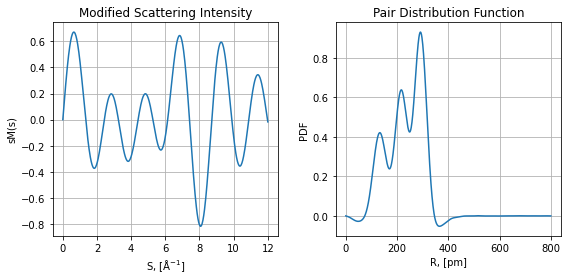

In [55]:
[I_1,I_at_1,I_mol_1,s_new] = get_I_from_xyz(f,s000,s_max, path_mol, mol_name, file_type);
[sM_new,PDF_new,r_new]       = get_sM_and_PDF_from_I(I_at,I_mol,s_new,r_max,damp_const)
# plot_I_sM_PDF(I,sM,PDF,s,r,mol_name+' I elastic',mol_name+' sM',mol_name+' PDF'); # use or not using plot-function 
plt.figure(figsize=(8,4))
    
plt.subplot(1,2,1)    
plt.plot(s_new,sM_new);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('sM(s)');plt.title('Modified Scattering Intensity');plt.grid()
    
plt.subplot(1,2,2)    
plt.plot(r_new,PDF_new);
plt.xlabel(r'R, [pm]');
plt.ylabel('PDF');
plt.title('Pair Distribution Function');
plt.grid()
    
plt.tight_layout()
plt.show()

In [65]:
dI_I_dump = (I-I_1)/I_1
dI_I_diss = (I_1-I)/(I)

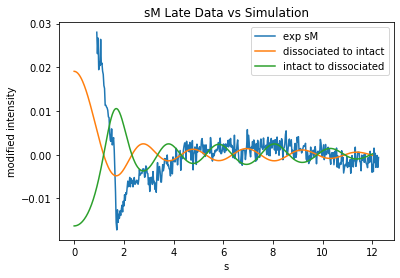

In [70]:
plt.figure()
plt.title("sM Late Data vs Simulation")
plt.plot(s, (earlydata), label = "exp sM")
plt.plot(s_new, dI_I_dump/50, label = "dissociated to intact")
plt.plot(s_new, dI_I_diss/30, label="intact to dissociated")
plt.xlabel("s")
plt.ylabel("modified intensity")
plt.legend()
plt.savefig((image_path + 'latedata v simulation'))
plt.show()

## Plotting Static Signal

In [64]:
def remove_nan_from_data(s_exp,I_exp):
    #this function is to cut off nans in the experimental data
    start=0 #the parameter start reveals the end of nans
    for i in range(len(I_exp)):
        if np.isnan(I_exp[i]) or I_exp[i]==0:
            I_exp[i]=0
            start+=1
        else:
            break

    I_exp=I_exp/I_exp.max()
    #normalize experimental data
    #if start==0:
     #   I_exp1=I_exp
      #  s1=s_exp
    #else:
    if start<20:
        start=20
    I_exp1=I_exp[start:]
    s1=s_exp[start:]

    return I_exp1,s1,start

def poly_remove_bkg(s1,data):
    z=np.polyfit(s1,data,2)
    p=np.poly1d(z)
    Ivals=p(s1)
    bkg_removed=data-Ivals
    return bkg_removed

def high_freq_filter(cutoff_freq,s_interval,data):
    fs=1/s_interval
    nyq=0.5*fs
    high=cutoff_freq/nyq
    b,a=signal.butter(5,high,btype='high',analog=False)
    filted_data = signal.filtfilt(b,a,data)
    return filted_data

def low_freq_filter(cutoff_freq,s_interval,data):
    fs=1/s_interval
    nyq=0.5*fs
    low=cutoff_freq/nyq
    b,a=signal.butter(5,low,btype='low',analog=False)
    filted_data = signal.filtfilt(b,a,data)
    return filted_data

def remove_bkg_exam(data,s_exp,cut_freq):
    fdata=high_freq_filter(cut_freq,s_exp[1]-s_exp[0],data[30:])
    pdata=poly_remove_bkg(s_exp[30:],data[30:])
    plt.plot(s_exp,data,label='raw data')
    plt.plot(s_exp[30:],fdata,label='low freq filted')
    plt.plot(s_exp[30:],pdata,label='poly remove bkg')
    plt.grid()
    plt.title('delta_I/I %')
    plt.xlabel('s/angs^-1')
    plt.legend()
    plt.show()
    return

def plot_delay_matrix(M,norm='',title=''):
    M=np.array(M)
    M=Image.fromarray(M)
    target_size=(200,150)
    new_image=M.resize(target_size)
    im=np.array(new_image)
    
    plt.figure(figsize=(12,8))
    pc=plt.imshow(im,norm=norm,cmap=plt.get_cmap('seismic'),alpha=0.65)
    plt.colorbar(pc)
    ax=plt.gca()
    plt.ylabel('delay',fontsize=20)
    plt.title(title,fontsize=20)
    plt.grid(axis='x',color='indigo',linestyle='--',linewidth=2)
    plt.grid(axis='y',color='olive',linestyle=':',linewidth=1.5)
    return

def DIOI_from_exp(s_exp,I_t,time_zero):
    I_t=np.array(I_t)
    t_count=len(np.transpose(I_t)[0])
    I_t1=get_2d_matrix(t_count,len(I_t[0]))
    Start=[0 for i in range(t_count)]
    S1=[0 for i in range(t_count)]
    for i in range(t_count):
        I_t1[i],S1[i],Start[i]=remove_nan_from_data(s_exp,I_t[i])
    Start=np.array(Start)
    start1=Start.max()
    s1=s_exp[start1:]
    I_t0=np.average(I_t1[time_zero:],axis=0)
    Delta_I_over_I=np.empty((t_count,len(s_exp)-start1))
    DIOI_bkg_removed=get_2d_matrix(t_count,len(s_exp))

    for i in range(t_count):
        I_t1[i]=I_t1[i][start1-Start[i]:]
        Delta_I_over_I[i]=(I_t1[i]-I_t0)/I_t0*100
        DIOI_bkg_removed[i][start1:]=poly_remove_bkg(s1,Delta_I_over_I[i])
        #DIOI_bkg_removed[i][start1:]=high_freq_filter(0.3,s_exp[1]-s_exp[0],Delta_I_over_I[i])
    
    return DIOI_bkg_removed,start1

def DOIO_T_rescale(TIME,s_exp,s_calibration,DIOI_bkg_removed,start,norm):
    DOIO_T_rescale=get_2d_matrix(600,len(DIOI_bkg_removed[0])+start)
    T1=np.array(TIME)
    t_axis_interval=(-T1.min()+T1.max())/10
    T_rescale=np.linspace(T1.min(),T1.max()+T1[-1]-T1[-2],600)
    position=np.empty(len(TIME)+1)
    position[-1]=len(T_rescale)
    m=0
    for i in range(len(T_rescale)):
        if m==len(TIME):
            break
        if T_rescale[i]>=TIME[m]:
            position[m]=i
            m+=1
    m=0
    for i in range(len(T_rescale)):
        if i>=position[m] and i<position[m+1]:
            DOIO_T_rescale[i]=DIOI_bkg_removed[m]
        else:
            m+=1
            DOIO_T_rescale[i]=DIOI_bkg_removed[m]
            
    plot_delay_matrix(DOIO_T_rescale,norm,'delta_I/I %')
    plt.xticks(np.arange(0,200,200/len(s_exp)/s_calibration),np.arange(0,len(s_exp)*s_calibration,1),fontsize=15)
    plt.yticks(np.arange(0,150,t_axis_interval*150/(T_rescale.max()-T_rescale.min())) \
    ,np.round(-np.arange(T_rescale.min(),T_rescale.max(),t_axis_interval),2),fontsize=15)
    plt.ylabel('delay/ps',fontsize=18)
    plt.xlabel('s/angs^-1',fontsize=18)
    plt.show()
    return

def DIOI_along_s(DIOI_bkg_removed,s_interval,TIME,delay_cut,s01):
    tDIOI=np.transpose(DIOI_bkg_removed)
    DIOIt1=np.empty(len(tDIOI[1]))
    a1=np.round(s01-0.2,2)
    b1=np.round(s01+0.2,2)
    for i in range(len(DIOIt1)):
        DIOIt1[i]=sum(DIOI_bkg_removed[i][int(a1/s_interval):int(b1/s_interval)])/16
    t=np.round(TIME[delay_cut:],2)
    return t,DIOIt1[delay_cut:]

def DIOI_s_plot(DIOI_bkg_removed,s_interval,TIME,delay_cut,s01):
    tDIOI=np.transpose(DIOI_bkg_removed)
    DIOIt1=np.empty(len(tDIOI[1]))
    a1=np.round(s01-0.2,2)
    b1=np.round(s01+0.2,2)
    for i in range(len(DIOIt1)):
        DIOIt1[i]=sum(DIOI_bkg_removed[i][int(a1/s_interval):int(b1/s_interval)])/16
    #DIOIt11=low_freq_filter(6,s_interval,DIOIt1)
    t=np.round(TIME[delay_cut:],2)
    plt.scatter(t,DIOIt1[delay_cut:],label=str(a1)+'<s<'+str(b1))
    #plt.plot(t,DIOIt11[delay_cut:])
    ax=plt.gca()
    ax.invert_xaxis()
    plt.grid()
    plt.legend(fontsize='12')
    plt.xlabel('delay/mm')
    plt.ylabel('percentage')
    plt.title('delta_I/I %')
    plt.show()
    return t,DIOIt1[delay_cut:]

def DIOI_water_fall(time_zero,DIOI_bkg_removed,time_s,s_exp,N,n_before_zero):
    DIOI=np.array(DIOI_bkg_removed)
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax2=fig.add_subplot(111, frame_on=False)
    fig.set_size_inches(8,N*0.9)
    T=[0 for i in range(N+2)]
    for i in range(N):
        k=time_zero-i+n_before_zero
        T[i+1]=-time_s[k]*1000
        ax.plot(s_exp,DIOI[k]+i/2)
        ax.axhline(y=i/2,linewidth='0.8',color='black')
    ax.set_xlabel('s/angs^-1',fontsize='15')
    ax.set_xticks(np.arange(0,1+np.round(s_exp.max(),0)))
    left=[0 for i in range(len(T))]
    for i in range(len(T)):
        left[i]=str(np.round(T[i],0))+'fs'
    left=np.array(left)
    ax.set_yticks(np.arange(-2,N)*0.5)
    plt.yticks(np.arange(-1,N+1)*0.5,left,fontsize='12')
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    ax.set_ylim(-0.49,0.5*N-0.01)
    ax2.set_ylim(-0.49,0.5*N-0.01)
    ax.set_ylabel('delta_I/I %',fontsize='15')
    ax.grid(axis='x')
    plt.show()
    return

def fit_errofunction(t,DI,initial_guess,co_bounds):
    def func(x,a,b,c,d):
        return -a*special.erf(b*(x-c))+d
    xdata=np.array(t)
    ydata=np.array(DI)
    popt,pcov=curve_fit(func,xdata,ydata,p0=initial_guess,maxfev=10000,bounds=([-co_bounds[0],0,0,0],co_bounds))
    a=popt[0]
    b=popt[1]
    c=popt[2]
    d=popt[3]
    t1=np.linspace(xdata.min(),xdata.max(),100)
    I_fit=-a*special.erf(b*(t1-c))+d
    return t1,I_fit,popt,pcov

def fit_time_zero(TIME,time_zero,t,DI,initial_guess,bounds):
    t1,DI_erf,C,pcov=fit_errofunction(t,DI,initial_guess,bounds)
    y=-C[0]*special.erf(C[1]*(t-C[2]))+C[3]
    r=mstats.pearsonr(DI,y)
    fig=plt.figure()
    fig.set_size_inches(8,5)
    plt.plot(t1,DI_erf)
    plt.scatter(t,DI)
    ax=plt.gca()
    ax.invert_xaxis()
    plt.title('delta_I/I %')
    plt.xlabel('delay/mm')
    ground_state_time=C[2]+3/C[1]/2**0.5
    sigma=1/C[1]/2**0.5
    plt.axvline(x=ground_state_time,linestyle='--',color='navy',linewidth='1.4')
    plt.axvline(x=TIME[time_zero],linestyle='--',color='indianred',linewidth='1.4')
    plt.legend(['y=a*erf(b*(x-c))+d\na='+str(np.round(C[0],4))+\
               '\nb='+str(np.round(C[1],7))+\
               '\nc='+str(np.round(C[2],7))+\
               '\nd='+str(np.round(C[3],7))+\
               '\npearson_r='+str(np.round(r[0],5)),'modified start','current start'])
    plt.grid()
    plt.show()
    print('sigma =',sigma,'mm')
    print('FWHM =',sigma*23550/3,'fs')
    return ground_state_time,C[2]

def iterate_time_zero(s_exp,I_t,time_zero,TIME,delay_cut,s01,initial_guess,bounds):
    time_zero1=-1
    m=0
    DIOI_bkg_removed,start=DIOI_from_exp(s_exp,I_t,time_zero)
    t,DI=DIOI_s_plot(DIOI_bkg_removed,s_exp[1]-s_exp[0],TIME,delay_cut,s01)
    while time_zero1!=time_zero:
        if m==1:
            time_zero=time_zero1
        DIOI_bkg_removed,start=DIOI_from_exp(s_exp,I_t,time_zero)
        I_time_zero=np.average(I_t[time_zero:],axis=0)
        t,DI=DIOI_along_s(DIOI_bkg_removed,s_exp[1]-s_exp[0],TIME,delay_cut,s01)
        ground_state_time,TIME_0=fit_time_zero(TIME,time_zero,t,DI,initial_guess,bounds)
        for tg in range(len(TIME)):
            if TIME[tg]>ground_state_time:
                break
        time_zero1=tg
        if time_zero1==time_zero:
            break
        else:
            m=1
    I_time_zero1=np.average(I_t[time_zero1:],axis=0)
    DIOI_bkg_removed1,start=DIOI_from_exp(s_exp,I_t,time_zero1)
    return DIOI_bkg_removed1,I_time_zero1,TIME_0,start

In [65]:
def find_zeros(I_mol,s):
    #this function is to find the s0 values at which the simulated I_mol equals 0
    zero_count=0
    zeros_max=30 #the total number of zero points should be no larger than this value
    s01=[0 for i in range(zeros_max)]
    for i in range(len(s)-1):
        if I_mol[i]*I_mol[i+1]<=0:
            #s01[zero_count]=s[i]
            s01[zero_count]=(I_mol[i]*s[i+1]-I_mol[i+1]*s[i])/(I_mol[i]-I_mol[i+1])
            zero_count+=1

    s0=s01[0:zero_count]

    return s0

def find_near_zeros(sM,s):
    #it is better to determine near zeros using sM instead of I_mol
    #because I_mol approaches zero at large angles
    zero_count=0
    zeros_max=50 
    s01=[0 for i in range(zeros_max)]
    for i in range(len(s)-1):
        if sM[i]*sM[i+1]<=0 and s[i]>1e-3 and s[i]-s01[zero_count-1]>0.1:
            s01[zero_count]=(sM[i]*s[i+1]-sM[i+1]*s[i])/(sM[i]-sM[i+1])
            zero_count+=1
        if sM[i]*sM[i+1]>0 and abs(sM[i]/sM.max())<0.000001 and s[i]-s01[zero_count-1]>0.1: 
            # abs(sM[i]/sM.max())<0.001 decides whether the point satisfies 'near zero'
            # set a number much smaller than 0.001 if three zeros are too close to each other
            # s[i]-s01[zero_count-1]>0.1 zeros too close to another are discarded
            s01[zero_count]=s[i]
            zero_count+=1

    s0=s01[0:zero_count]
    return s0

def get_I_exp_at_zeros(s_exp,I_exp,s0):
    m=0
    filted_I_exp=low_freq_filter(1.5,s_exp[1]-s_exp[0],I_exp)
    I_0=[0 for i in range(len(s0))]
    for i in range(len(s_exp)-1):
        if abs(s_exp[i]-s0[m])<3e-4:
            I_0[m]=filted_I_exp[i]
            m+=1
            if m==len(s0):
                break
        elif abs(s_exp[i+1]-s0[m])<3e-4:
            I_0[m]=filted_I_exp[i]
            m+=1
            if m==len(s0):
                break
        elif s_exp[i]<s0[m] and s_exp[i+1]>s0[m]:
            I_0[m]=(filted_I_exp[i+1]-filted_I_exp[i])/(s_exp[i+1]-s_exp[i])*(s0[m]-s_exp[i+1])+filted_I_exp[i+1]
            m+=1
            if m==len(s0):
                break
    return I_0

def fit_every_3_points(s0,I_0,s_exp):
    A=np.empty(len(s0)-2)
    B=np.empty(len(s0)-2)
    C=np.empty(len(s0)-2)
    I_frag=np.empty((len(s0)-2,len(s_exp)))
    for i in range(len(s0)-2):
        s1=s0[i]
        s2=s0[i+1]
        s3=s0[i+2]
        g1=np.log(I_0[i])
        g2=np.log(I_0[i+1])
        g3=np.log(I_0[i+2])
    
        alpha1=(g2-g1)/(g3-g1)
        alpha2=(g3-g1)/(g3-g2)
        c=np.linspace(-3,3,800)
        h=alpha1*(s3**c-s1**c)-s2**c+s1**c+alpha2*(s3**c-s2**c)-s3**c+s1**c
        
        c0=find_zeros(h,c)
        
        for j in c0:
            if abs(j)>0.001:
                c_zero=j

        b=((g2-g1)/(s2**c_zero-s1**c_zero)+(g3-g1)/(s3**c_zero-s1**c_zero))/2
        a=(g1-b*s1**c_zero+g2-b*s2**c_zero+g3-b*s3**c_zero)/3
        A[i]=a
        B[i]=b
        C[i]=c_zero
        I_frag[i]=np.exp(a+b*s_exp**c_zero)
        
    I_fit=[0 for i in range(len(s_exp))]
    m=0
    m_max=len(s0)-1
    for i in range(len(s_exp)):
        if s_exp[i]>=s0[m] and m<m_max:
            m+=1
        if m<=1:
            I_fit[i]=I_frag[0,i]
        if m>=len(s0)-1:
            I_fit[i]=I_frag[m_max-2,i]
        if m>1 and m<len(s0)-1:
            I_fit[i]=I_frag[m-2,i]*(s_exp[i]-s0[m-1])/(s0[m]-s0[m-1])+I_frag[m-1,i]*(s0[m]-s_exp[i])/(s0[m]-s0[m-1])

    return I_fit

def fit_background(s0,I_0,s1):
    def func(x,a,b,c,d):
        return c*np.exp(-a*x**b)+d
    xdata=np.array(s0)
    ydata=np.array(I_0)
    popt,pcov=curve_fit(func,xdata,ydata,p0=[1.3,0.7,1,1],maxfev = 10000,bounds=(0,[3,3,10,10]))
    a=popt[0]
    b=popt[1]
    c=popt[2]
    d=popt[3]
    I_fit=c*np.exp(-a*s1**b)+d
    return I_fit

def rescale_along_y_axis(fstandard,ftoscale):
    fstandard=np.array(fstandard)
    ftoscale=np.array(ftoscale)
    if len(fstandard)!=len(ftoscale):
        print('error! fstandard and ftoscale should have the same length!')
        return
    scale=sum(fstandard**2)/sum(fstandard*ftoscale)
    return ftoscale*scale,scale

def retrieve_PDF(left,right,s_interval1,f,s000,s_max, path_mol, mol_name, file_type, damp_const,r_max,I_exp):
    coor, atom_sum = load_static_mol_coor(path_mol,mol_name,file_type)
    s_exp=np.linspace(0,(len(I_exp)-1)*s_interval1,len(I_exp))
    I,I_at,I_mol=get_I_for_exp_from_mol_coor(f,s000,s_exp,coor,atom_sum)
    I_exp1,s1,start=remove_nan_from_data(s_exp,I_exp)
    I_at1=I_at[start:]
    sM,PDF,r=get_sM_and_PDF_from_I(I_at,I_mol,s_exp,r_max,damp_const)
    s0=find_near_zeros(sM,s_exp)
    print('zeros:')
    print(s0)
    
    for i in range(len(s_exp)):
        if s_exp[i]>=s0[0]:
            start1=i
            break
    cut=start1-start
    I_0=get_I_exp_at_zeros(s1,I_exp1,s0)
    #I_fit=fit_background(s0,I_0,s1)
    I_fit=fit_every_3_points(s0,I_0,s1)

    I_mol_ret=I_exp1-I_fit
    I_mol_ret_filted=low_freq_filter(1.5,s_interval1,I_mol_ret)#filt high frequency noices
    sM_ret,PDF_awful,r=get_sM_and_PDF_from_I(I_at1,I_mol_ret_filted,s1,r_max,damp_const)
    sM_ret=sM_ret/sM_ret.max()
    
    I1,I_at1,I_mol1,s11=get_I_from_mol_coor(f,s000,s_max,coor,atom_sum)
    sM1,PDF1,r=get_sM_and_PDF_from_I(I_at1,I_mol1,s11,r_max,damp_const)

    sM_combined=np.empty(len(s_exp))
    sM_combined[start1:]=sM_ret[cut:]
    
    j=0
    for i in range(len(s_exp)):
        if s_exp[i]>=left and j==0:
            st=i
            j=1
        if s_exp[i]>=right:
            en=i
            break

    st1=st-start
    en1=en-start
    #sM_ret1,sc1=rescale_along_y_axis(sM[st:en],sM_ret[st1:en1])
    #sMscale=1/sc1
    sMscale=1/(sum(abs(sM[st:en]))/sum(abs(sM_ret[st1:en1])))
    
    sM_combined[:start1]=sM[:start1]*sMscale

    PDF_ret=[0 for i in range(r_max)]
    for i in range(len(s_exp)-1): 
        PDF_ret+=sM_combined[i]*np.sin(s_exp[i]*1e10*np.array(r)*1e-12)*(s_exp[i+1]-s_exp[i])*np.exp(-s_exp[i]**2/damp_const)
    
    PDF_ret_scaled,sc3=rescale_along_y_axis(PDF1,PDF_ret)
    fig=plt.figure(figsize=(8,4))
    # fig.set_size_inches(10,5)
    plt.subplot(121)
    plt.plot(s1,I_exp1,label='experimental data')
    plt.scatter(s0,I_0)
    plt.plot(s1,I_fit,label='fitted background')
    plt.plot(s1,I_mol_ret,label='retrieved I_mol')
    plt.grid()
    plt.legend(loc="best")
    plt.xlabel('s/angs^-1')
    plt.title('fit scattering background')

    plt.subplot(122)
    plt.plot(s_exp,sM*sMscale,label='simulation',linestyle='--',linewidth='3')
    plt.plot(s1,sM_ret,label='experiment',linewidth='2')
    plt.axvline(x=s_exp[st],linestyle='--',color='firebrick',label='rescale begin')
    plt.axvline(x=s_exp[en],linestyle='--',color='firebrick',label='rescale end')
    plt.title('retrieved sM')
    plt.grid()
    plt.xlabel('s/angs^-1')
    #plt.legend(loc="best")
    plt.show()
    
    fig=plt.figure(figsize=(8,4))
    # fig.set_size_inches(10,5)
    plt.subplot(121)
    plt.plot(s11,sM1*np.exp(-s11**2/damp_const),label='simulation',linestyle='--',linewidth='3')
    plt.plot(s_exp,sM_combined/(sum(abs(sM_combined[st:en]))/sum(abs(sM1[st:en])))*np.exp(-s_exp**2/damp_const),label='experiment',linewidth='2')
    plt.legend()
    plt.title('damped sM')
    plt.axvline(x=s_exp[start1],linestyle='--',color='black',label='cut')
    plt.axvline(x=s_exp[st],linestyle='--',color='firebrick')
    plt.axvline(x=s_exp[en],linestyle='--',color='firebrick')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('s/angs^-1')
    
    plt.subplot(122)
    plt.plot(r,PDF1,label='simulation',linestyle='--',linewidth='3')
    plt.plot(r,PDF_ret_scaled,label='experiment',linewidth='2.5')
    plt.title('retrieved ground state PDF')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('r/pm')
    plt.tight_layout()
    plt.show()
    
    return

def sM_err(left,right,s_interval1,f,s000,s_max,coor,atom_sum,damp_const,r_max,I_exp):
    s_exp=np.linspace(0,(len(I_exp)-1)*s_interval1,len(I_exp))
    I,I_at,I_mol=get_I_for_exp_from_mol_coor(f,s000,s_exp,coor,atom_sum)
    I_exp1,s1,start=remove_nan_from_data(s_exp,I_exp)
    I_at1=I_at[start:]
    sM,PDF,r=get_sM_and_PDF_from_I(I_at,I_mol,s_exp,r_max,damp_const)
    s0=find_near_zeros(sM,s_exp)
    
    for i in range(len(s_exp)):
        if s_exp[i]>=s0[0]:
            start1=i
            break
    cut=start1-start
    I_0=get_I_exp_at_zeros(s1,I_exp1,s0)
    #I_fit=fit_background(s0,I_0,s1)
    I_fit=fit_every_3_points(s0,I_0,s1)

    I_mol_ret=I_exp1-I_fit
    I_mol_ret_filted=low_freq_filter(1.5,s_interval1,I_mol_ret)#filt high frequency noices
    sM_ret=s1*I_mol_ret_filted/I_at1

    j=0
    for i in range(len(s_exp)):
        if s_exp[i]>=left and j==0:
            st=i
            j=1
        if s_exp[i]>=right:
            en=i
            break
    st1=st-start
    en1=en-start

    s_good=s_exp[st:en]
    #sMscale=1/(sum(abs(sM[st:en]))/sum(abs(sM_ret[st1:en1])))
    
    sM_ret1,sc1=rescale_along_y_axis(sM[st:en],sM_ret[st1:en1])

    r=scipy.stats.mstats.pearsonr(sM_ret1*np.exp(-s_good**2/damp_const),sM[st:en]*np.exp(-s_good**2/damp_const))
    #r=mstats.pearsonr(sM_ret[st1:en1],sM_sim*sMscale)
    
    return r[0]

def scan_s_calibration(scmin,scmax,left,right,f,s000,s_max,coor,atom_sum,damp_const,r_max,I_ground_state):
    interval1=0.0002
    interval2=0.00002
    R1=np.empty(int((scmax-scmin)/interval1))
    R2=np.empty(int(2*interval1/interval2))
    for i in range(int((scmax-scmin)/interval1)):
        R1[i]=sM_err(left,right,scmin+i*interval1,f,s000,s_max,coor,atom_sum,damp_const,r_max,I_ground_state)

    a=np.where(R1==R1.max())
    s_calibration1=scmin+interval1*int(a[0])

    for i in range(int(2*interval1/interval2)):
        R2[i]=sM_err(left,right,s_calibration1-interval1+i*interval2,f,s000,s_max,coor,atom_sum,damp_const,r_max,I_ground_state)

    x=np.linspace(-2,2,5)
    h=np.exp(-x**2/200)
    c=signal.convolve(R2,h,mode='same')
    c=c[2:-2]

    b=np.where(c==c.max())
    s_calibration2=s_calibration1-interval1+interval2*(int(b[0])+2)
    print('s_calibration:',s_calibration2,'angs^-1/pixel')
    #print('pearson_r:',R2[int(b[0])+2])
    return s_calibration2

In [66]:
path_mol='packages/Molecular_coordinates/';     # The molecular .xyz/.csv pathes
mol_name='cf3i_opt';file_type='.xyz'; # Molecular geometries, .xyz or .csv file, coordinates saved in 'Molecular_coordinates'

f     = import_DCS(55) # Form factor (partial scattering crosssecton), loadint the IAM form factor with z<55, probably enough for most of orgnic molecules
s000  = import_s()     # Q axis 
s_max = 12             # Max Q range
r_max = 800            # Max R range in pm
damp_const= 35        # damping factor

left   = 1.5   # Left side range in S
right  = 9.5     # Right side range in S

s_cali = scan_s_calibration(0.0215, 0.025, left,right,f,s000,s_max,coor,atom_sum,damp_const,r_max, norm_ref)
print(s_cali)

s_calibration: 0.02478 angs^-1/pixel
0.02478


zeros:
[1.3404506116199213, 2.4276993677920977, 3.252347651525164, 4.436124414605781, 5.2901337396586605, 6.092779518485185, 7.427279606370176, 8.854259093291848, 9.966071588236789, 10.902297320826825]


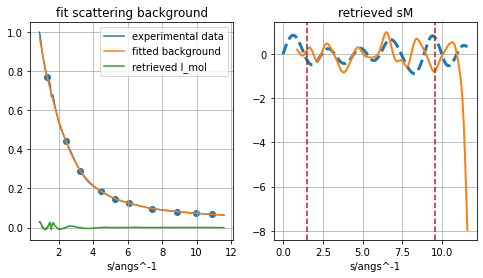

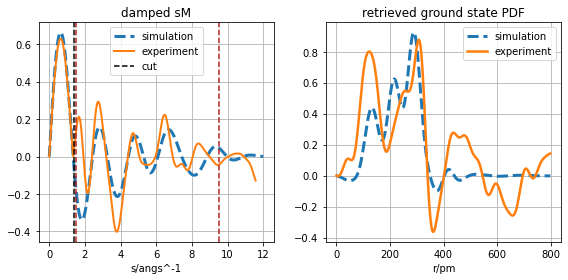

In [67]:
# (4) Extratin the static scattering signal
#s_cali = 0.02478
#[coor,atom_sum]  = load_static_mol_coor(path_mol,mol_name,file_type);
[I,I_at,I_mol,s] = get_I_from_xyz(f,s000,s_max,coor,atom_sum);
# [sM,PDF,r]       = get_sM_and_PDF_from_I(I_at,I_mol,s,r_max,damp_const)


I_ground_state=norm_ref; # experimental static scattering signal
#I_ground_state = np.nanmean(norm_data[5:20], axis=0)

retrieve_PDF(left,right,s_cali,f,s000,s_max,path_mol, mol_name, file_type ,damp_const,r_max,I_ground_state);# function to retrive to retrive the static signal

## Simulating Fragmentation

Simulates a diffraction pattern based on the a unimolecular dissociation following: 

\begin{equation}
reactant \longrightarrow fragment_1 + fragment_2
\end{equation}

where the sum of fragments = reactant. __Code can take any number of fragments.__ 

In [90]:
angs = '\u00C5' # Angstrom sign
path_mol='packages/Molecular_coordinates/'; # The molecular .xyz/.csv pathes
# path_dcs='/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/';
reactant='cf3i_opt';
products = ['cf3', 'i']
#reactant = 'cf3i_opt'
#products = ['cf3', 'i']

file_type='.xyz'; # Molecular geometries, .xyz or .csv file, coordinates saved in 'Molecular_coordinates'

f=import_DCS(55)
s000=import_s()
s_max = 12 # Max Q range
r_max = 800  # Max R range
damp_const=33

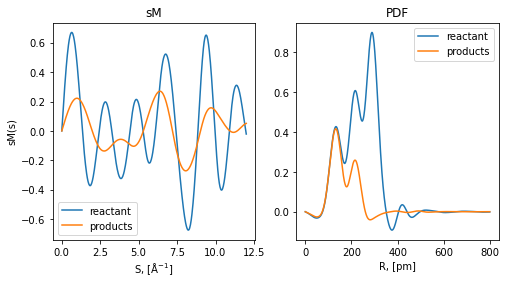

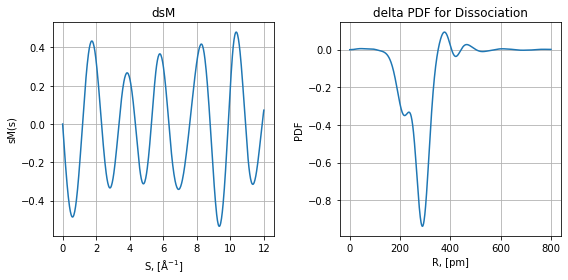

In [91]:
dsM, s_sim, dPDF, r_sim = dissoc_sim(path_mol, reactant, products, file_type, f, s000, s_max)

plt.figure(figsize=(8,4))
    
plt.subplot(1,2,1)    
plt.plot(s_sim,dsM);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('sM(s)');
plt.title('dsM');
plt.grid()
    
plt.subplot(1,2,2)    
plt.plot(r_sim,dPDF);
plt.xlabel(r'R, [pm]');
plt.ylabel('PDF');
plt.title('delta PDF for Dissociation');
plt.grid()
    
plt.tight_layout()
plt.show()

In [1062]:
def I_dissoc(path_mol, products, file_type, f, s000, s_exp, r_max=800, damp_const=33):
    I_at_tot = []
    I_mol_tot = []
    I_tot = []
    coor_tot = []
    atom_tot = []
    for i in range(len(products)):
        frag_name = str(products[i])
        print(frag_name)
        coor, atom_sum = load_static_mol_coor(path_mol,frag_name,file_type)
        I,I_at,I_mol = get_I_for_exp_from_mol_coor(f,s000,s_exp,coor,atom_sum)
        I_tot.append(I)
        I_at_tot.append(I_at)
        I_mol_tot.append(I_mol)
        coor_tot.append(coor)
        atom_tot.append(atom_sum)
    
    I_at_tot = np.sum(I_at_tot, axis=0)
    I_mol_tot = np.sum(I_mol_tot, axis=0)
    I_tot = np.sum(I_tot, axis=0)
    atom_tot = np.sum(atom_tot)

    return coor_tot, atom_tot, I_tot, I_at_tot, I_mol_tot

def retrieve_PDF(left,right,s_interval1,f,s000,s_max,path_mol, mol_name, file_type, damp_const,r_max,I_exp, dis='no'):
    s_exp=np.linspace(0,(len(I_exp)-1)*s_interval1,len(I_exp))
    print(len(s_exp))
    if dis=='no':
        coor, atom_sum = load_static_mol_coor(path_mol,mol_name,file_type)
        I,I_at,I_mol=get_I_for_exp_from_mol_coor(f,s000,s_exp,coor,atom_sum)
    elif dis=='yes':
        print("dissociation sim")
        coor, atom_sum, I, I_at, I_mol = I_dissoc(path_mol, mol_name, file_type, f, s000, s_exp) 
    I_exp1,s1,start=remove_nan_from_data(s_exp,I_exp)
    I_at1=I_at[start:]
    sM,PDF,r=get_sM_and_PDF_from_I(I_at,I_mol,s_exp,r_max,damp_const)
    s0=find_near_zeros(sM,s_exp)
    print('zeros:')
    print(s0)
    
    for i in range(len(s_exp)):
        if s_exp[i]>=s0[0]:
            start1=i
            break
    cut=start1-start
    I_0=get_I_exp_at_zeros(s1,I_exp1,s0)
    #I_fit=fit_background(s0,I_0,s1)
    I_fit=fit_every_3_points(s0,I_0,s1)

    I_mol_ret=I_exp1-I_fit
    I_mol_ret_filted=low_freq_filter(1.5,s_interval1,I_mol_ret)#filt high frequency noices
    sM_ret,PDF_awful,r=get_sM_and_PDF_from_I(I_at1,I_mol_ret_filted,s1,r_max,damp_const)
    sM_ret=sM_ret/sM_ret.max()
    
    if dis=='no':
        I1,I_at1,I_mol1,s11=get_I_from_xyz(f,s000,s_max,coor,atom_sum)
        sM1,PDF1,r=get_sM_and_PDF_from_I(I_at1,I_mol1,s11,r_max,damp_const)
    elif dis=='yes':
        I_at1 = []
        I_mol1 = []
        I1 = []
        for i in range(len(products)):
            frag_name = str(products[i])
            print(frag_name)
            coor, atom_sum = load_static_mol_coor(path_mol,frag_name,file_type)
            I,I_at,I_mol, s11 = get_I_from_xyz(f,s000,s_max,coor,atom_sum)
            I1.append(I)
            I_at1.append(I_at)
            I_mol1.append(I_mol)

        I_at1 = np.sum(I_at1, axis=0)
        I_mol1 = np.sum(I_mol1, axis=0)
        I1 = np.sum(I1, axis=0)
        sM1, PDF1, r = get_sM_and_PDF_from_I(I_at1, I_mol1, s11, r_max, damp_const)

        

    sM_combined=np.empty(len(s_exp))
    sM_combined[start1:]=sM_ret[cut:]
    
    j=0
    for i in range(len(s_exp)):
        if s_exp[i]>=left and j==0:
            st=i
            j=1
        if s_exp[i]>=right:
            en=i
            break

    st1=st-start
    en1=en-start
    #sM_ret1,sc1=rescale_along_y_axis(sM[st:en],sM_ret[st1:en1])
    #sMscale=1/sc1
    sMscale=1/(sum(abs(sM[st:en]))/sum(abs(sM_ret[st1:en1])))
    
    sM_combined[:start1]=sM[:start1]*sMscale

    PDF_ret=[0 for i in range(r_max)]
    for i in range(len(s_exp)-1): 
        PDF_ret+=sM_combined[i]*np.sin(s_exp[i]*1e10*np.array(r)*1e-12)*(s_exp[i+1]-s_exp[i])*np.exp(-s_exp[i]**2/damp_const)
    
    PDF_ret_scaled,sc3=rescale_along_y_axis(PDF1,PDF_ret)
    fig=plt.figure(figsize=(8,4))
    # fig.set_size_inches(10,5)
    plt.subplot(121)
    plt.plot(s1,I_exp1,label='experimental data')
    plt.scatter(s0,I_0)
    plt.plot(s1,I_fit,label='fitted background')
    plt.plot(s1,I_mol_ret,label='retrieved I_mol')
    plt.grid()
    plt.legend(loc="best")
    plt.xlabel('s/angs^-1')
    plt.title('fit scattering background')

    plt.subplot(122)
    plt.plot(s_exp,sM*sMscale,label='simulation',linestyle='--',linewidth='3')
    plt.plot(s1,sM_ret,label='experiment',linewidth='2')
    plt.axvline(x=s_exp[st],linestyle='--',color='firebrick',label='rescale begin')
    plt.axvline(x=s_exp[en],linestyle='--',color='firebrick',label='rescale end')
    plt.title('retrieved sM')
    plt.grid()
    plt.xlabel('s/angs^-1')
    #plt.legend(loc="best")
    plt.show()
    
    fig=plt.figure(figsize=(8,4))
    # fig.set_size_inches(10,5)
    plt.subplot(121)
    plt.plot(s11,sM1*np.exp(-s11**2/damp_const),label='simulation',linestyle='--',linewidth='3')
    plt.plot(s_exp,sM_combined/(sum(abs(sM_combined[st:en]))/sum(abs(sM1[st:en])))*np.exp(-s_exp**2/damp_const),label='experiment',linewidth='2')
    plt.legend()
    plt.title('damped sM')
    plt.axvline(x=s_exp[start1],linestyle='--',color='black',label='cut')
    plt.axvline(x=s_exp[st],linestyle='--',color='firebrick')
    plt.axvline(x=s_exp[en],linestyle='--',color='firebrick')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('s/angs^-1')
    
    plt.subplot(122)
    plt.plot(r,PDF1,label='simulation',linestyle='--',linewidth='3')
    plt.plot(r,PDF_ret_scaled,label='experiment',linewidth='2.5')
    plt.title('retrieved ground state PDF')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('r/pm')
    plt.tight_layout()
    plt.show()
    
    return

475
dissociation sim
cf3
i
zeros:
[1.9773939347905949, 5.305532186870943, 7.200485927618325, 9.023490224755514, 10.933789243428864, 11.411552246190354]
cf3
i


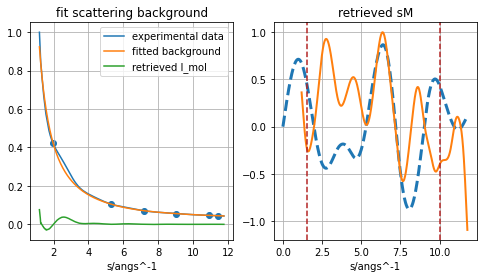

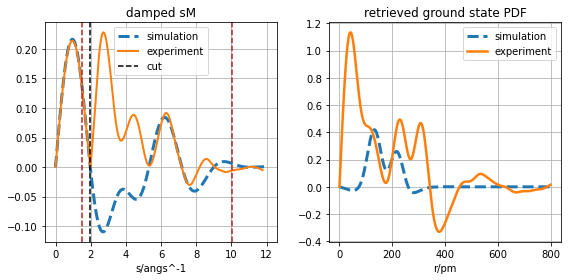

In [1069]:
# (4) Extratin the static scattering signal
#s_cali = 0.02478
# [sM,PDF,r]       = get_sM_and_PDF_from_I(I_at,I_mol,s,r_max,damp_const)
left   = 1.5   # Left side range in S
right  = 10     # Right side range in S

#I_ground_state=norm_ref; # experimental static scattering signal
I_ground_state = np.nanmean(norm_data[:10], axis=0)

retrieve_PDF(left,right,s_cali,f,s000,s_max,path_mol, products, file_type ,damp_const,r_max,I_ground_state, 'yes');
# function to retrive to retrive the static signal